## Start

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import yaml
import tqdm


In [3]:
all_qs = []
for topic in glob.glob('../questions/topics/*'):
    if 'Demo' not in topic:
        with open(f"{topic}/questions.yaml") as f:
            all_qs.extend(yaml.safe_load(f))

all_qs = pd.DataFrame(all_qs)
correct_answers = dict(zip(all_qs['Id'], all_qs['MultipleChoice'].apply(lambda r: r['Correct'])))

In [4]:
all_user_data = []

for file in glob.glob('../backend/users/*.yaml'):
    if 'demo' not in file:
        with open(file) as f:
            data = yaml.safe_load(f)

        if 'pretest' in data:
            data['pretest'] = pd.DataFrame(data['pretest'])
        if 'questionSchedule' not in data:
            continue
        
        qSchedule = []
        for i, day in enumerate(data['questionSchedule']):
            for j, q in enumerate(day):
                q['day'] = i
                q['numInDay'] = j
                qSchedule.append(q)
        data['questionSchedule'] = pd.DataFrame(qSchedule)

        if 'posttestA' in data:
            data['posttestA'] = pd.DataFrame(data['posttestA'])
        if 'posttestB' in data:
            data['posttestB'] = pd.DataFrame(data['posttestB'])
        if 'sleepData' in data:
            data['sleepData'] = np.array([float(d['numHours']) for d in data['sleepData']])

        all_user_data.append(data)

all_user_data = pd.DataFrame(all_user_data)

In [5]:
# list all emails (after the @ sign) from all_user_data["email"]
all_user_data["email"].apply(lambda x: x.split("@")[1]).value_counts()

jhmi.edu             12
som.umaryland.edu    10
jh.edu                6
usf.edu               4
med.miami.edu         2
quinnipiac.edu        1
gmail.com             1
Name: email, dtype: int64

In [6]:
len(all_user_data)

36

In [7]:
# bad_emails = []
bad_emails = ['madison.evans@som.umaryland.edu', 'puja.patel@som.umaryland.edu', 'kran2@jh.edu', 'charles1@usf.edu']

'''
# shamil34@jhmi.edu 0.3103448275862069
# shannon.hanggodo@quinnipiac.edu 0.26153846153846155
madison.evans@som.umaryland.edu 0.0
# aweitzn1@jh.edu 0.3142857142857143
# mkubica1@jhmi.edu 0.30158730158730157
# mmarani1@jhmi.edu 0.2564102564102564
# aatkin31@jhmi.edu 0.35526315789473684
puja.patel@som.umaryland.edu 0.04225352112676056
# slin86@jhmi.edu 0.328125
# kkuhn14@jh.edu 0.3442622950819672
# kzhu24@jhmi.edu 0.18181818181818182
# xdai9@jhmi.edu 0.3770491803278688
# lyoung1090@gmail.com 0.22857142857142856
charles1@usf.edu 0.20588235294117646
kran2@jh.edu 0.0
'''

finished_study_data = all_user_data[all_user_data['status'].isin(['posttestDone', 'studyDone', 'posttestPartADone']) & ~all_user_data['email'].isin(bad_emails)]
finished_users = finished_study_data['email'].unique()
print(f"Participants who finished study portion: {len(finished_study_data)}\n{finished_users}")

Participants who finished study portion: 24
['rguilba1@jh.edu' 'csong29@jhmi.edu' 'shamil34@jhmi.edu'
 'logan.kolakowski@som.umaryland.edu' 'shannon.hanggodo@quinnipiac.edu'
 'aweitzn1@jh.edu' 'mkubica1@jhmi.edu' 'nichole.shaw@som.umaryland.edu'
 'psingh34@jh.edu' 'jfogel@som.umaryland.edu' 'mmarani1@jhmi.edu'
 'lauren.sands@som.umaryland.edu' 'aatkin31@jhmi.edu' 'slin86@jhmi.edu'
 'robert.liu@som.umaryland.edu' 'pvikram1@jhmi.edu'
 'andrewbharris@jhmi.edu' 'kkuhn14@jh.edu' 'szhan129@jh.edu'
 'maria.novitskaya@som.umaryland.edu' 'kzhu24@jhmi.edu' 'xdai9@jhmi.edu'
 'lyoung1090@gmail.com' 'tzhang1@som.umaryland.edu']


In [8]:
finished_post_data = all_user_data[all_user_data['status'].isin(['posttestDone']) & ~all_user_data['email'].isin(bad_emails)].reset_index()
print(f"Participants who finished all post-tests: {len(finished_post_data)}\n{finished_post_data['email'].to_list()}")

Participants who finished all post-tests: 24
['rguilba1@jh.edu', 'csong29@jhmi.edu', 'shamil34@jhmi.edu', 'logan.kolakowski@som.umaryland.edu', 'shannon.hanggodo@quinnipiac.edu', 'aweitzn1@jh.edu', 'mkubica1@jhmi.edu', 'nichole.shaw@som.umaryland.edu', 'psingh34@jh.edu', 'jfogel@som.umaryland.edu', 'mmarani1@jhmi.edu', 'lauren.sands@som.umaryland.edu', 'aatkin31@jhmi.edu', 'slin86@jhmi.edu', 'robert.liu@som.umaryland.edu', 'pvikram1@jhmi.edu', 'andrewbharris@jhmi.edu', 'kkuhn14@jh.edu', 'szhan129@jh.edu', 'maria.novitskaya@som.umaryland.edu', 'kzhu24@jhmi.edu', 'xdai9@jhmi.edu', 'lyoung1090@gmail.com', 'tzhang1@som.umaryland.edu']


## Fraction contested

Calculating fraction contested overall and per user

In [85]:
with open('../backend/scoring/contestedEvaluations.yaml') as f:
    contested_evaluations = pd.DataFrame(yaml.safe_load(f))

In [86]:
count = 0
users_seen = set()
for _, row in contested_evaluations.iterrows():
    if row['user'] not in finished_users:
      continue
    user_row = finished_post_data[finished_post_data['email'] == row['user']]
    qSched = user_row['questionSchedule'].iloc[0]
    qSched_row = qSched[qSched['qid'] == row['QID']].iloc[0]
    if qSched_row['modality'] == 'mc':
      print('oops..')
      print(row)
      contested_evaluations = contested_evaluations[~((contested_evaluations['user'] == row['user']) & (contested_evaluations['timestamp'] == row['timestamp']))]

    if row['user'] not in users_seen:
      count = count + 1
      users_seen.add(row['user'])

print(f"{count} users contested at least 1 score")
contested_evaluations

oops..
QID                                Pediatrics 12
userResponse                Sprengel's deformity
score                                          1
user                             aweitzn1@jh.edu
timestamp       2023-01-27 21:31:08.929000+00:00
Name: 173, dtype: object
21 users contested at least 1 score


,QID,userResponse,score,user,timestamp
0,Trauma 27,pain management,1,robert.liu@som.umaryland.edu,2022-10-24 02:00:34.569000+00:00
1,Pediatrics 23,surgical correction,1,robert.liu@som.umaryland.edu,2022-10-24 17:12:04.286000+00:00
2,Recon 10,decreased strength and ductility,0,tzhang1@som.umaryland.edu,2022-10-24 21:34:15.682000+00:00
3,Recon 4,back side where,0,tzhang1@som.umaryland.edu,2022-10-24 21:38:33.780000+00:00
4,Pediatrics 7,increased pull out strength,1,andrewbharris@jhmi.edu,2022-10-24 22:16:56.174000+00:00
...,...,...,...,...,...
246,Pediatrics 10,Calcaneus fracture,1,hgupta4@jhmi.edu,2023-02-15 04:08:10.830000+00:00
247,Trauma 28,AIr embolism,1,hgupta4@jhmi.edu,2023-02-15 04:09:52.388000+00:00
248,Recon 23,Septic arthritis,1,hgupta4@jhmi.edu,2023-02-15 04:11:54.801000+00:00
249,Recon 15,dysplasia,1,hgupta4@jhmi.edu,2023-02-15 04:16:55.032000+00:00


Percentage of overall responses contested: 7.92% +/- 1.46%


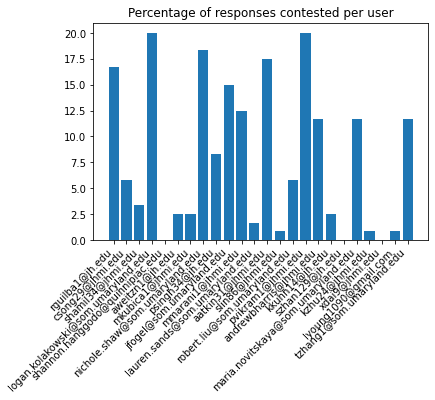

In [87]:
total_questions = 120

frac_contested = len(contested_evaluations[contested_evaluations['user'].isin(finished_users)]) / (len(finished_users) * total_questions)
frac_contested_per_user = {user: (contested_evaluations['user'] == user).sum() / total_questions for user in finished_users}
print(f"Percentage of overall responses contested: {100 * frac_contested:.2f}% +/- {100 * scipy.stats.sem([x for x in frac_contested_per_user.values()]):.2f}%")

plt.title('Percentage of responses contested per user')
plt.bar(frac_contested_per_user.keys(), np.array(list(frac_contested_per_user.values())) * 100)
plt.xticks(rotation=45, ha='right')
plt.show()

In [17]:
contested_evaluations['correct'] = [correct_answers[qid] for qid in contested_evaluations['QID']]
contested_evaluations

,QID,userResponse,score,user,timestamp,correct
0,Trauma 27,pain management,1,robert.liu@som.umaryland.edu,2022-10-24 02:00:34.569000+00:00,Immediate mobilization and weight bearing as t...
1,Pediatrics 23,surgical correction,1,robert.liu@som.umaryland.edu,2022-10-24 17:12:04.286000+00:00,Observation and clinical follow-up
2,Recon 10,decreased strength and ductility,0,tzhang1@som.umaryland.edu,2022-10-24 21:34:15.682000+00:00,Increased elastic modulus and decreased strength
3,Recon 4,back side where,0,tzhang1@som.umaryland.edu,2022-10-24 21:38:33.780000+00:00,Polyethylene fretting wear debris from the bac...
4,Pediatrics 7,increased pull out strength,1,andrewbharris@jhmi.edu,2022-10-24 22:16:56.174000+00:00,Increased maximal insertional torque
...,...,...,...,...,...,...
246,Pediatrics 10,Calcaneus fracture,1,hgupta4@jhmi.edu,2023-02-15 04:08:10.830000+00:00,Decreased risk of posttraumatic arthritis
247,Trauma 28,AIr embolism,1,hgupta4@jhmi.edu,2023-02-15 04:09:52.388000+00:00,Sexual dysfunction (dyspareunia) and caesarean...
248,Recon 23,Septic arthritis,1,hgupta4@jhmi.edu,2023-02-15 04:11:54.801000+00:00,Patella baja
249,Recon 15,dysplasia,1,hgupta4@jhmi.edu,2023-02-15 04:16:55.032000+00:00,Excessive femoral neck anteversion and a poste...


In [13]:
questions = contested_evaluations['QID'].map(lambda qid: all_qs['Question'][all_qs['Id'] == qid].item())
contested_evaluations_save = pd.DataFrame({
    'QID': contested_evaluations['QID'],
    'Figures': ['']*len(contested_evaluations),
    'Question': questions,
    'User Response': contested_evaluations['userResponse'],
    'Correct Response': contested_evaluations['correct'],
    'Was User Correct?': ['']*len(contested_evaluations),
    'Comments': ['']*len(contested_evaluations),
    'SAIL Score': contested_evaluations['score'],
    'User': contested_evaluations['user']
})

writer = pd.ExcelWriter('contested_evaluations.xlsx', engine='xlsxwriter')
contested_evaluations_save.to_excel(writer, sheet_name='Sheet1')
writer.sheets['Sheet1'].set_default_row(300)

for i, qid in enumerate(contested_evaluations['QID']):
    topic = ' '.join(qid.split(' ')[:-1])
    figs = all_qs['Figures'][all_qs['Id'] == qid].item()
    if isinstance(figs, list):
        for f in figs:
            writer.sheets['Sheet1'].insert_image(i+1, 2, f'../questions/topics/{topic}/{f}')

writer.save()

In [14]:
import docx

document = docx.Document()
questions = contested_evaluations['QID'].map(lambda qid: all_qs['Question'][all_qs['Id'] == qid].item())

for i in range(len(contested_evaluations)):
    r = document.add_paragraph().add_run()
    r.add_text(f"QID: {contested_evaluations['QID'][i]}")
    r.add_text(f"Question: {questions[i]}")
    r.add_text(f"User Response {contested_evaluations['userResponse'][i]}")
    r.add_text(f"Correct Response: {contested_evaluations['correct'][i]}")

document.save('contested_evaluations.docx')

contested_evaluations_save = pd.DataFrame({
    'QID': contested_evaluations['QID'],
    'Figures': ['']*len(contested_evaluations),
    'Question': questions,
    'User Response': contested_evaluations['userResponse'],
    'Correct Response': contested_evaluations['correct'],
    'Was User Correct?': ['']*len(contested_evaluations),
    'Comments': ['']*len(contested_evaluations),
    'SAIL Score': contested_evaluations['score'],
    'User': contested_evaluations['user']
})

writer = pd.ExcelWriter('contested_evaluations.xlsx', engine='xlsxwriter')
contested_evaluations_save.to_excel(writer, sheet_name='Sheet1')
writer.sheets['Sheet1'].set_default_row(300)

for i, qid in enumerate(contested_evaluations['QID']):
    topic = ' '.join(qid.split(' ')[:-1])
    figs = all_qs['Figures'][all_qs['Id'] == qid].item()
    if isinstance(figs, list):
        for f in figs:
            writer.sheets['Sheet1'].insert_image(i+1, 2, f'../questions/topics/{topic}/{f}')

writer.save()

## Reliability of voice transcription

Calculating fraction of times they edited voice transcription, overall and per user

In [10]:
num_voice_responses = 60
voice_edited_responses = finished_study_data['questionSchedule'].apply(
    lambda qs: qs[(qs['modality'] == 'voice') & (qs['userResponse'].str.strip().str.lower() != qs['originalResponse'].str.strip().str.lower())])

Percentage of overall responses edited: 52.43% +/- 5.60%


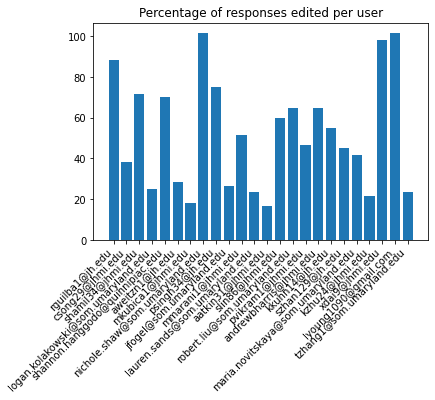

In [11]:
frac_edited_per_user = voice_edited_responses.apply(len) / num_voice_responses

print(f"Percentage of overall responses edited: {100 * frac_edited_per_user.mean():.2f}% +/- {100 * frac_edited_per_user.sem():.2f}%")

plt.title('Percentage of responses edited per user')
plt.bar(finished_study_data['email'], frac_edited_per_user * 100)
plt.xticks(rotation=45, ha='right')
plt.show()

In [13]:
# Study example response edits
voice_edited_responses[finished_study_data['email'] == 'andrewbharris@jhmi.edu'].squeeze()


,finished,modality,originalResponse,qid,score,started,userResponse,day,numInDay
0,2022-10-24 22:07:09.532000+00:00,voice,None,Pediatrics 25,0,2022-10-24 22:06:17.636000+00:00,osteotomies,0,0
1,2022-10-24 22:12:27.114000+00:00,voice,None,Recon 2,1,2022-10-24 22:11:59.180000+00:00,proximal tib-fib joint disruption,0,1
3,2022-10-24 22:16:48.583000+00:00,voice,decrease pull out strength increase Plus,Pediatrics 7,1,2022-10-24 22:16:29.192000+00:00,increased pull out strength,0,3
6,2022-10-24 22:19:40.781000+00:00,voice,genital scapula syndrome,Pediatrics 12,0,2022-10-24 22:19:21.747000+00:00,congenital scapula syndrome,0,6
31,2022-10-25 11:53:22.515000+00:00,voice,see the fascia play Bear Song.,Recon 19,1,2022-10-25 11:52:55.088000+00:00,Weightbearing as tolerated,1,12
32,2022-10-25 11:54:30.871000+00:00,voice,follow up with,Recon 17,1,2022-10-25 11:53:54.639000+00:00,follow up with hip precautions,1,13
34,2022-10-25 11:55:11.073000+00:00,voice,Aeropostale pleasure and hypotension,Trauma 14,0,2022-10-25 11:54:56.500000+00:00,Narrowed pulse pressure,1,15
36,2022-10-25 11:56:38.075000+00:00,voice,syrupy,Pediatrics 11,1,2022-10-25 11:56:25.194000+00:00,CRP,1,17
43,2022-10-26 15:36:25.999000+00:00,voice,None,Recon 28,1,2022-10-26 15:35:54.256000+00:00,anterior inferior,2,6
44,2022-10-26 15:36:34.012000+00:00,voice,None,Pediatrics 27,0,2022-10-26 15:36:28.188000+00:00,scoliosis,2,7


## Study Performance per Modality

[]

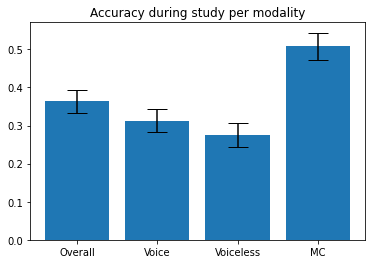

In [14]:
def calc_study_accuracy(qs, modality=None):
    if modality is not None:
        qs = qs[qs['modality'] == modality]
    return qs['score'].mean()

overall = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs)).mean()
voice = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, 'voice')).mean()
voiceless = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, 'voiceless')).mean()
mc = finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, 'mc')).mean()

sems = [finished_study_data['questionSchedule'].apply(lambda qs: calc_study_accuracy(qs, modality)).sem() for modality in [None, "voice", "voiceless", "mc"]]

plt.title('Accuracy during study per modality')
plt.bar(['Overall', 'Voice', 'Voiceless', 'MC'], [overall, voice, voiceless, mc], yerr=sems, alpha=1, ecolor='black', capsize=10)
plt.plot()


## Improvement per Modality

In [15]:
def calc_test_accuracies(test_type, modality, test_method):
    accs = []
    for _, row in finished_post_data.iterrows():
        qSched = row['questionSchedule']
        if modality == 'all':
            modality_qids = qSched['qid'].unique()
        else:
            modality_qids = qSched['qid'][qSched['modality'] == modality].unique()

        test = row[test_type.split(".")[0]]
        if "." in test_type:
            test = test[test_type.split(".")[1]]
        
        test = pd.DataFrame(test)
        if test_method == 'recognition':
            accuracy = np.mean([test['response'][i] == correct_answers[test['QID'][i]]
                                for i in range(len(test)) if test['QID'][i] in modality_qids])
        elif test_method == 'recall':
            accuracy = np.mean([test['automated_recall_score'][i]
                                for i in range(len(test)) if test['QID'][i] in modality_qids])
        
        accs.append(accuracy)
    
    return accs

pretest_acc = calc_test_accuracies('pretest', 'all', test_method="recognition")
posttest_recall_acc = []
posttest_recognition_acc = []

for posttest_iteration in ['first_posttest', 'second_posttest', 'posttest']:
    recall_testname = f'{posttest_iteration}.A'
    recog_testname = f'{posttest_iteration}.B'
    if posttest_iteration == "posttest":
        recall_testname = "posttestA"
        recog_testname = "posttestB"
    
    posttest_recall_acc.append({modality: calc_test_accuracies(recall_testname, modality, test_method='recall')
                                for modality in ['all', 'voice', 'voiceless', 'mc']})
    posttest_recognition_acc.append({modality: calc_test_accuracies(recog_testname, modality, test_method="recognition")
                                     for modality in ['all', 'voice', 'voiceless', 'mc']})



In [16]:
def calc_test_stats(test_type, modality):
    stats = []
    for _, row in finished_post_data.iterrows():
        qSched = row['questionSchedule']
        if modality == 'all':
            modality_qids = qSched['qid'].unique()
        else:
            modality_qids = qSched['qid'][qSched['modality'] == modality].unique()

        test = row[test_type.split(".")[0]]
        if "." in test_type:
            test = test[test_type.split(".")[1]]
        
        test = pd.DataFrame(test)
        dataaaa = []
        dataaaa = [i for i in range(len(test)) if test['QID'][i] in modality_qids]
        
        stats.append(len(dataaaa))
    
    return stats


for modality in ["all", "voice", "voiceless", "mc"]:
    # calculate how many questions were included for each post-test test
    arr = calc_test_stats("first_posttest.A", modality)
    # print median, 25th percentile, 75th percentile
    print(modality, np.median(arr), np.percentile(arr, 25), np.percentile(arr, 75))


all 62.0 52.75 67.0
voice 21.0 17.75 23.0
voiceless 20.5 17.5 22.0
mc 20.5 17.5 22.0


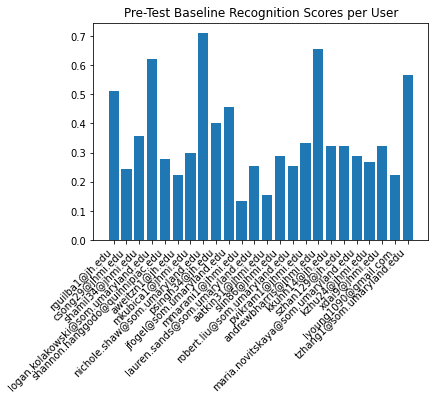

In [17]:
plt.rcParams.update({'font.size': 10})

bar_width = 0.5
plt.title('Pre-Test Baseline Recognition Scores per User')
plt.bar(finished_post_data['email'], pretest_acc, alpha=1, ecolor='black', capsize=10)
plt.xticks(rotation=45, ha='right')
plt.show()

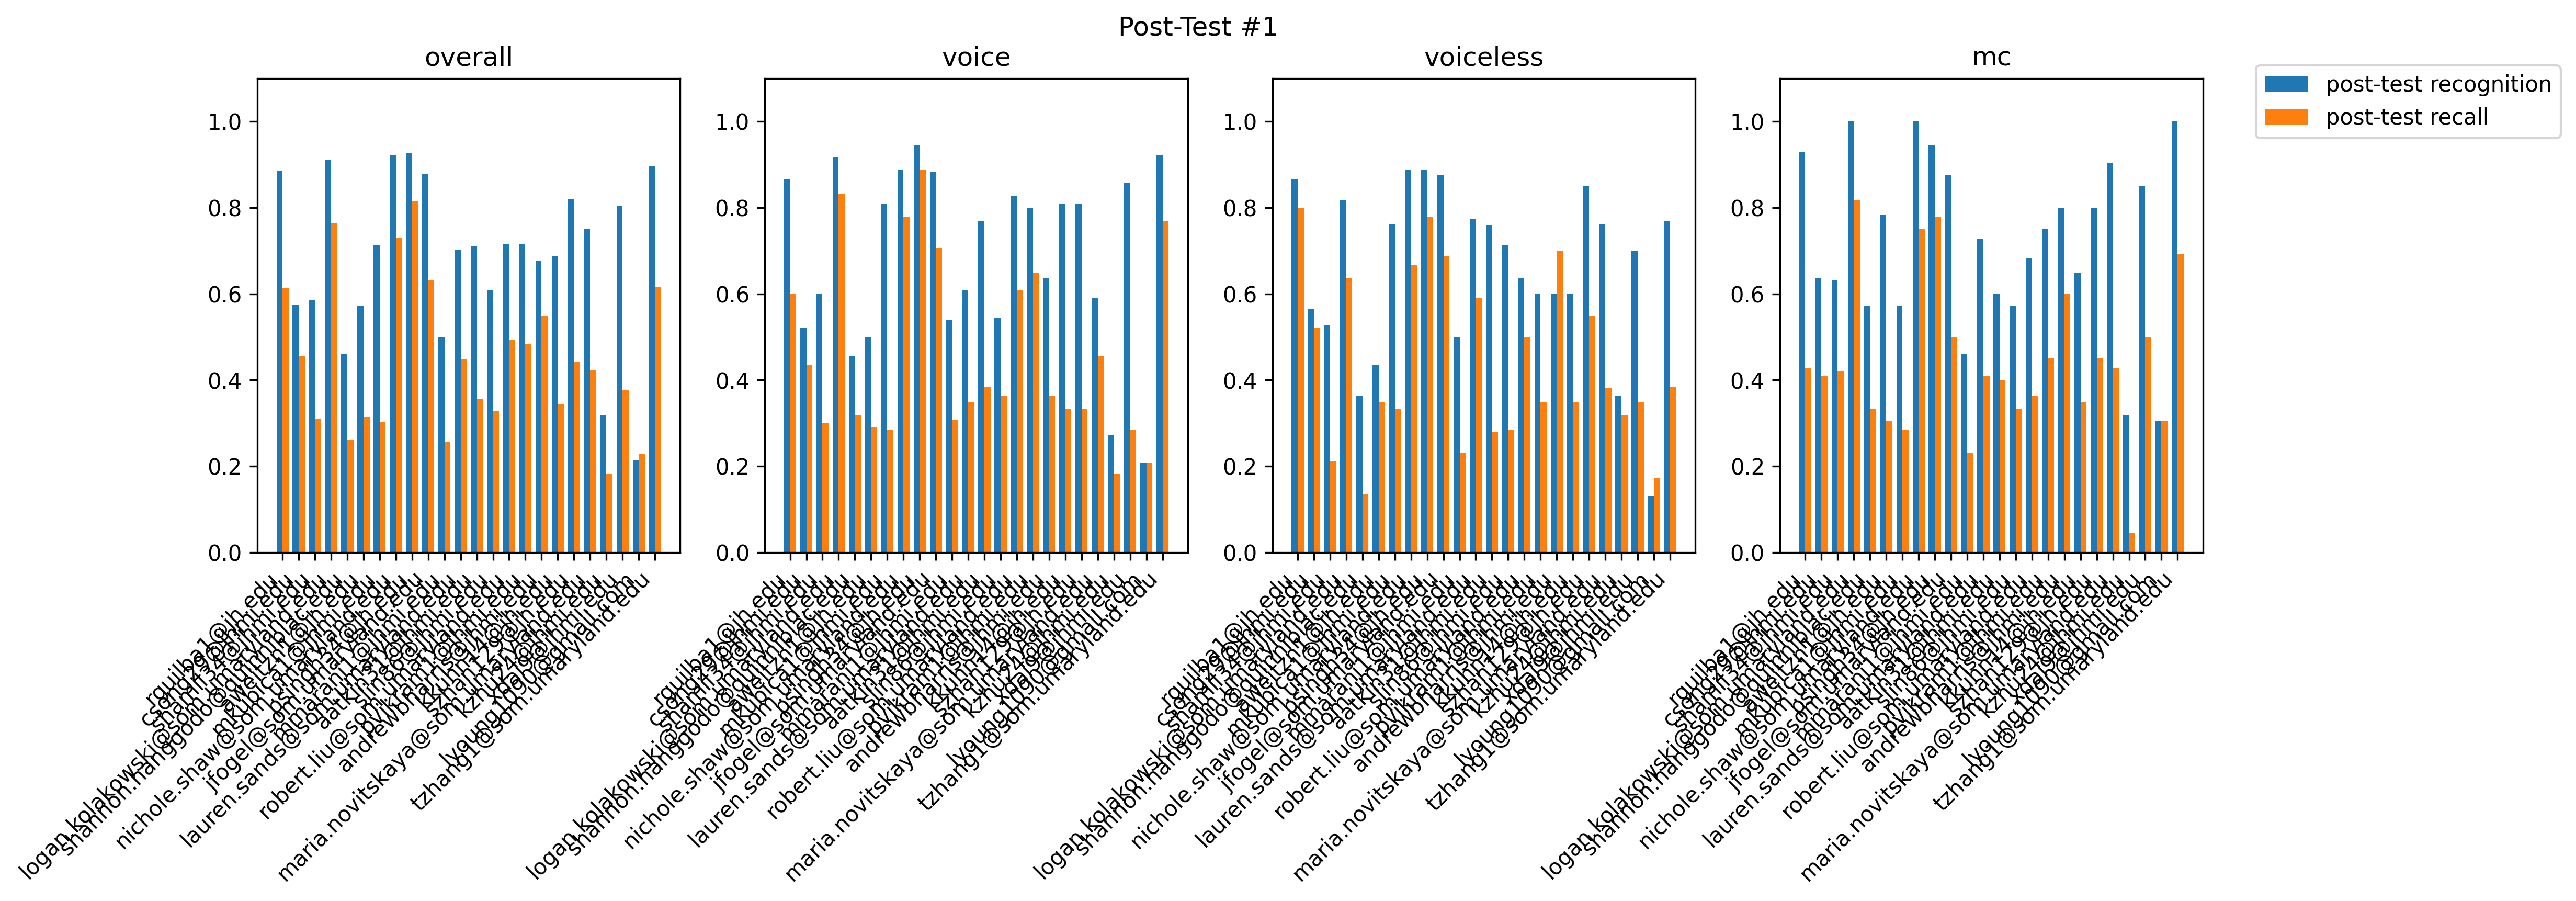

shamil34@jhmi.edu 0.3
shannon.hanggodo@quinnipiac.edu 0.3181818181818182
aweitzn1@jh.edu 0.2916666666666667
mkubica1@jhmi.edu 0.2857142857142857
mmarani1@jhmi.edu 0.3076923076923077
lauren.sands@som.umaryland.edu 0.34782608695652173
aatkin31@jhmi.edu 0.38461538461538464
slin86@jhmi.edu 0.36363636363636365
andrewbharris@jhmi.edu 0.36363636363636365
kkuhn14@jh.edu 0.3333333333333333
szhan129@jh.edu 0.3333333333333333
kzhu24@jhmi.edu 0.18181818181818182
xdai9@jhmi.edu 0.2857142857142857
lyoung1090@gmail.com 0.20833333333333334


In [18]:
fig, ax = plt.subplots(1, 4, figsize=(16, 4), dpi=300)
bar_width = 0.375
for i, modality in enumerate(['all', 'voice', 'voiceless', 'mc']):
    ax[i].set_title(f'{modality}' if modality != 'all' else "overall")
    ax[i].set_ylim(0, 1.1)
    ax[i].bar(np.arange(len(finished_post_data)) + bar_width,
              posttest_recognition_acc[0][modality], width=bar_width, label='post-test recognition')
    ax[i].bar(np.arange(len(finished_post_data)) + (2 * bar_width),
              posttest_recall_acc[0][modality], width=bar_width, label='post-test recall')

    ax[i].set_xticks(np.arange(len(finished_post_data)) + 1.5 * bar_width,
                     finished_post_data['email'], rotation=45, ha='right')

plt.suptitle("Post-Test #1")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

for i, score in enumerate(posttest_recall_acc[0]["voice"]):
    if score < 0.4:
        print(finished_post_data['email'][i], score)


Test 1
voice
Recall 0.4595266075924644 +- 0.04312317363430282
Recog 0.6908482581996008 +- 0.04220206851771325
voiceless
Recall 0.4401313257627617 +- 0.039973849925404786
Recog 0.6561694365999285 +- 0.04004253803942385
mc
Recall 0.44106588914941325 +- 0.03687807682490555
Recog 0.7233655744310777 +- 0.04092142375698077
Test 2
voice
Recall 0.393093273000562 +- 0.03781951215553751
Recog 0.6453141280666855 +- 0.037417058613998445
voiceless
Recall 0.4333518158360836 +- 0.04328107390516517
Recog 0.6343404364778793 +- 0.03912739364301773
mc
Recall 0.4503482546989412 +- 0.04485064015608418
Recog 0.6636075378981557 +- 0.04411939206915354
Test 3
voice
Recall 0.3299925709532487 +- 0.035481230977392864
Recog 0.5659876725174039 +- 0.0398770552565083
voiceless
Recall 0.29762709846090857 +- 0.0338094395545647
Recog 0.5408605199730772 +- 0.040312957659891784
mc
Recall 0.3022555817085279 +- 0.038964038302922166
Recog 0.5743721948076925 +- 0.04002726332196178


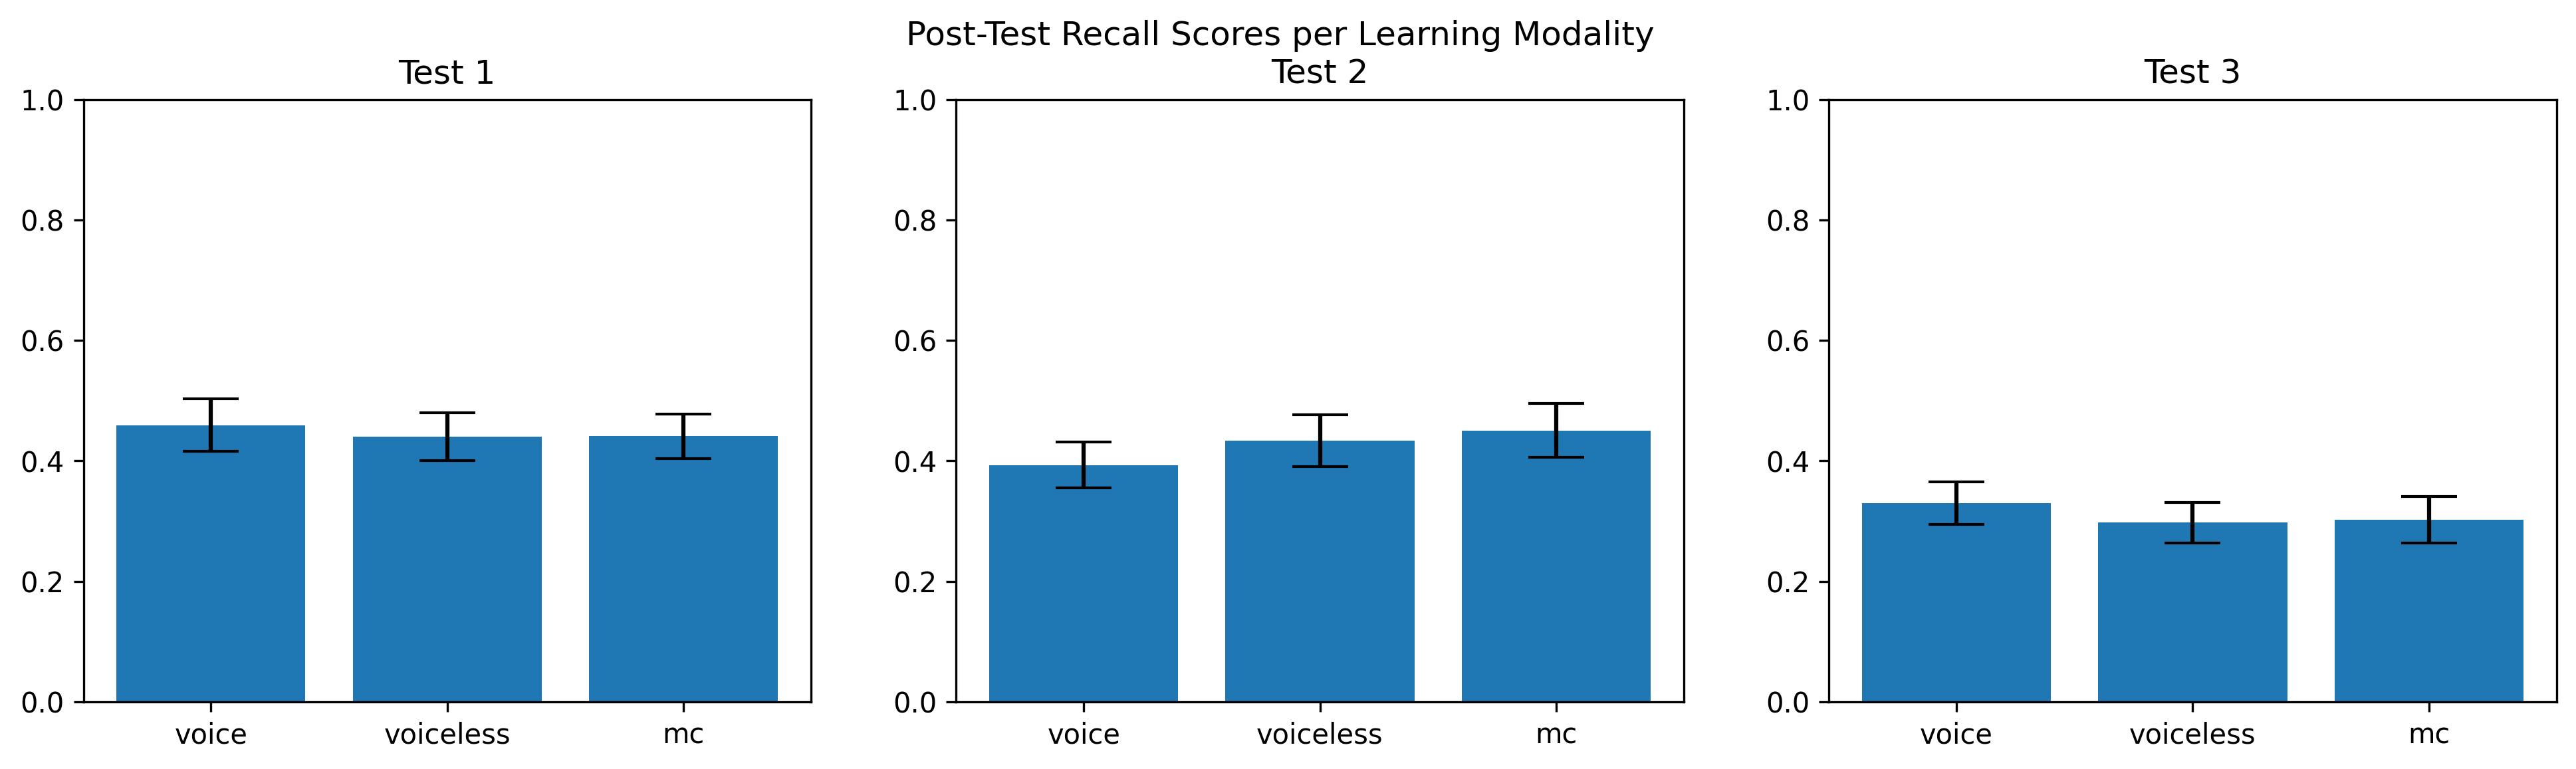

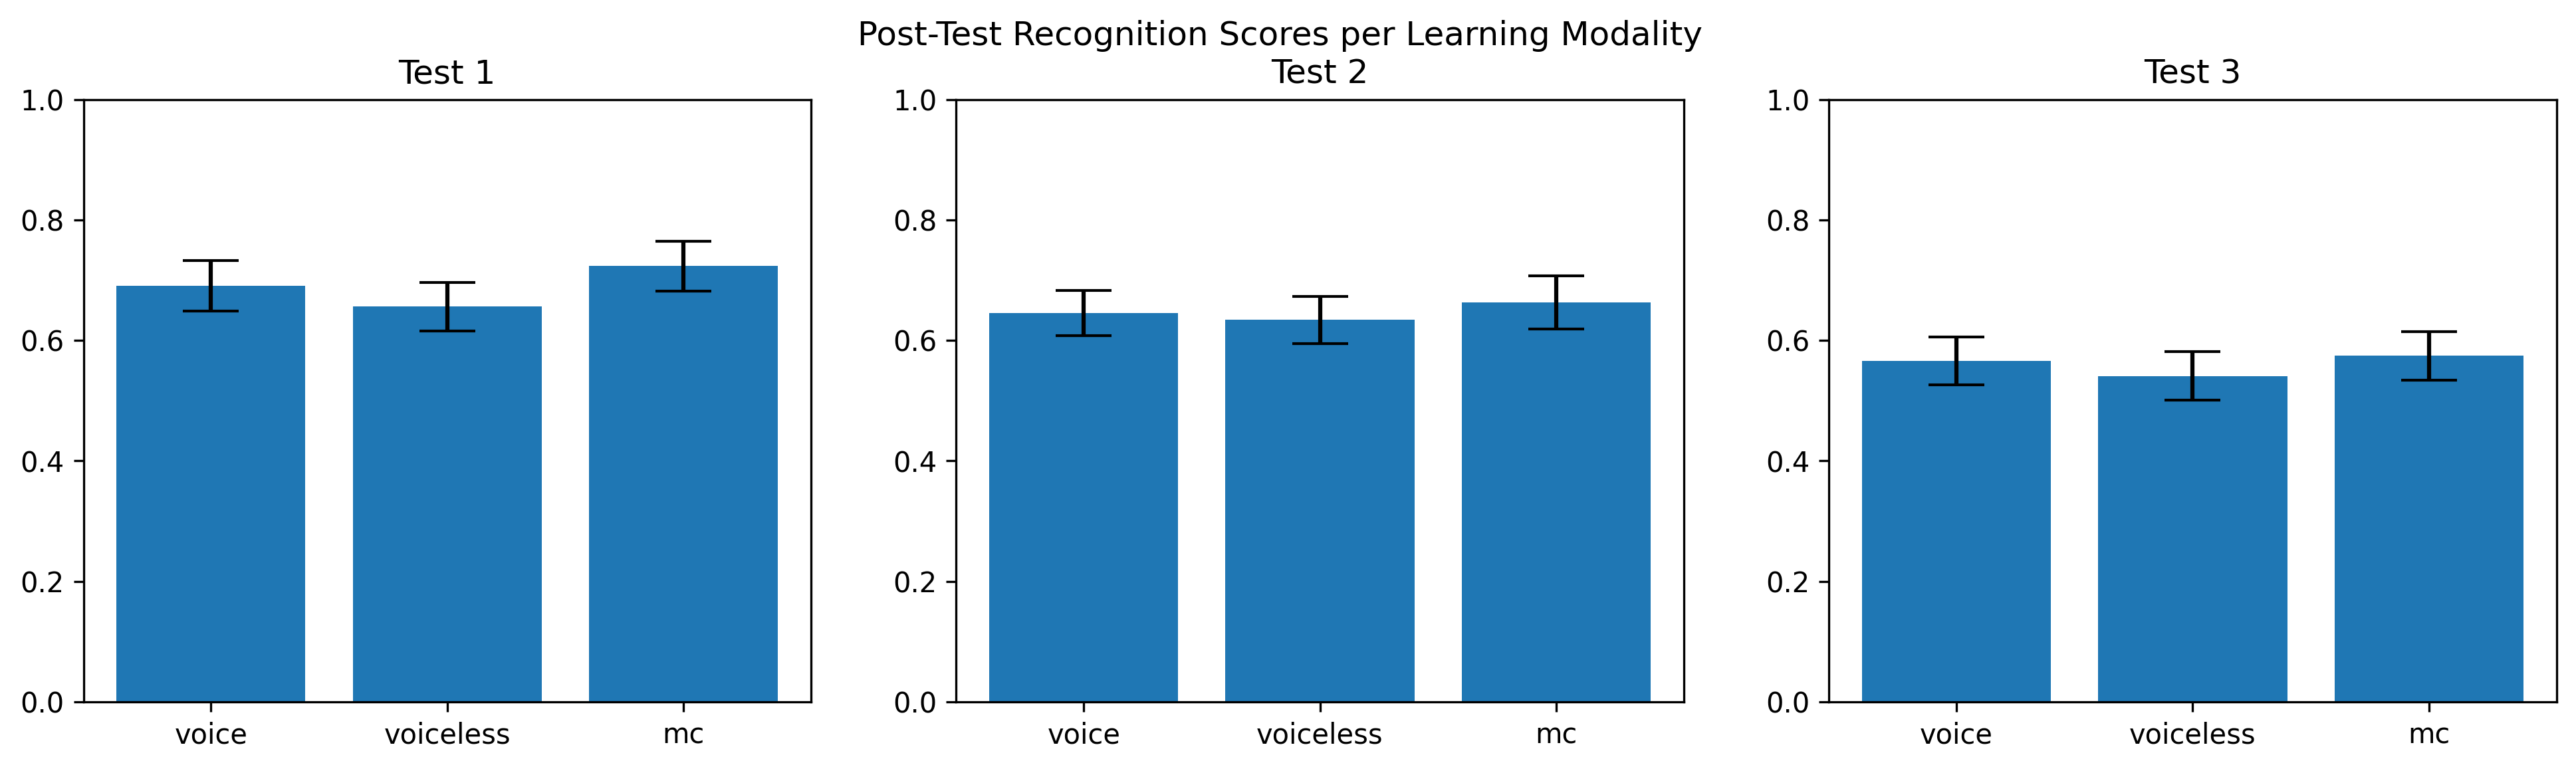

In [19]:
mean_posttest_recall_acc = [{modality: np.mean(np.subtract(accs, 0)) for modality, accs in posttest_recall_acc[i].items() if modality != "all"} for i in range(3)] 
mean_posttest_recall_sem = [{modality: scipy.stats.sem(np.subtract(accs, 0)) for modality, accs in posttest_recall_acc[i].items() if modality != "all"} for i in range(3)]
mean_posttest_recognition_acc = [{modality: np.mean(np.subtract(accs, 0)) for modality, accs in posttest_recognition_acc[i].items() if modality != "all"} for i in range(3)]
mean_posttest_recognition_sem = [{modality: scipy.stats.sem(np.subtract(accs, 0)) for modality, accs in posttest_recognition_acc[i].items() if modality != "all"} for i in range(3)]

for i in range(3):
    print(f"Test {i + 1}")
    for modality in ["voice", "voiceless", "mc"]:
      print(f"{modality}")
      print(f"Recall {mean_posttest_recall_acc[i][modality]} +- {mean_posttest_recall_sem[i][modality]}")
      print(f"Recog {mean_posttest_recognition_acc[i][modality]} +- {mean_posttest_recognition_sem[i][modality]}")
    
# mean_posttest_recall_acc = [{modality: np.mean(accs) for modality, accs in posttest_recall_acc[i].items() if modality != "all"} for i in range(3)] 
# mean_posttest_recall_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recall_acc[i].items() if modality != "all"} for i in range(3)]
# mean_posttest_recognition_acc = [{modality: np.mean(accs) for modality, accs in posttest_recognition_acc[i].items() if modality != "all"} for i in range(3)]
# mean_posttest_recognition_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recognition_acc[i].items() if modality != "all"} for i in range(3)]


fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].bar(np.arange(3), mean_posttest_recall_acc[i].values(), yerr=mean_posttest_recall_sem[i].values(), alpha=1, ecolor='black', capsize=10)
  neg_vals = []
  for val in mean_posttest_recall_acc[i].values():
    if val > 0:
      neg_vals.append(0)
    else:
      neg_vals.append(val)
  ax[i].bar(np.arange(3), neg_vals, alpha=1, color='r')
  ax[i].axis(ymin=0, ymax=1)
  ax[i].set_xticks(np.arange(3), mean_posttest_recall_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")

fig.suptitle('Post-Test Recall Scores per Learning Modality')
fig.show()


fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].bar(np.arange(3), mean_posttest_recognition_acc[i].values(), yerr=mean_posttest_recognition_sem[i].values(), alpha=1, ecolor='black', capsize=10)
  neg_vals = []
  for val in mean_posttest_recognition_acc[i].values():
    if val > 0:
      neg_vals.append(0)
    else:
      neg_vals.append(val)
  ax[i].bar(np.arange(3), neg_vals, alpha=1, color='r')
  ax[i].axis(ymin=0, ymax=1)
  ax[i].set_xticks(np.arange(3), mean_posttest_recognition_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")

fig.suptitle('Post-Test Recognition Scores per Learning Modality')
fig.show()

Recall Test 1
all p-value: 0.248946413397789
voice p-value: 0.008257235400378704
voiceless p-value: 0.15228191018104553
mc p-value: 0.11198808997869492
Recall Test 2
all p-value: 0.8739112615585327
voice p-value: 0.46956712007522583
voiceless p-value: 0.445622980594635
mc p-value: 0.3139718174934387
Recall Test 3
all p-value: 0.7473322153091431
voice p-value: 0.7883694767951965
voiceless p-value: 0.2517048418521881
mc p-value: 0.014609581790864468
Recognition Test 1
all p-value: 0.0861564427614212
voice p-value: 0.029230033978819847
voiceless p-value: 0.056485410779714584
mc p-value: 0.2672399580478668
Recognition Test 2
all p-value: 0.3966873288154602
voice p-value: 0.19843325018882751
voiceless p-value: 0.05408928170800209
mc p-value: 0.3171711266040802
Recognition Test 3
all p-value: 0.16375166177749634
voice p-value: 0.23675405979156494
voiceless p-value: 0.3363330662250519
mc p-value: 0.321755975484848


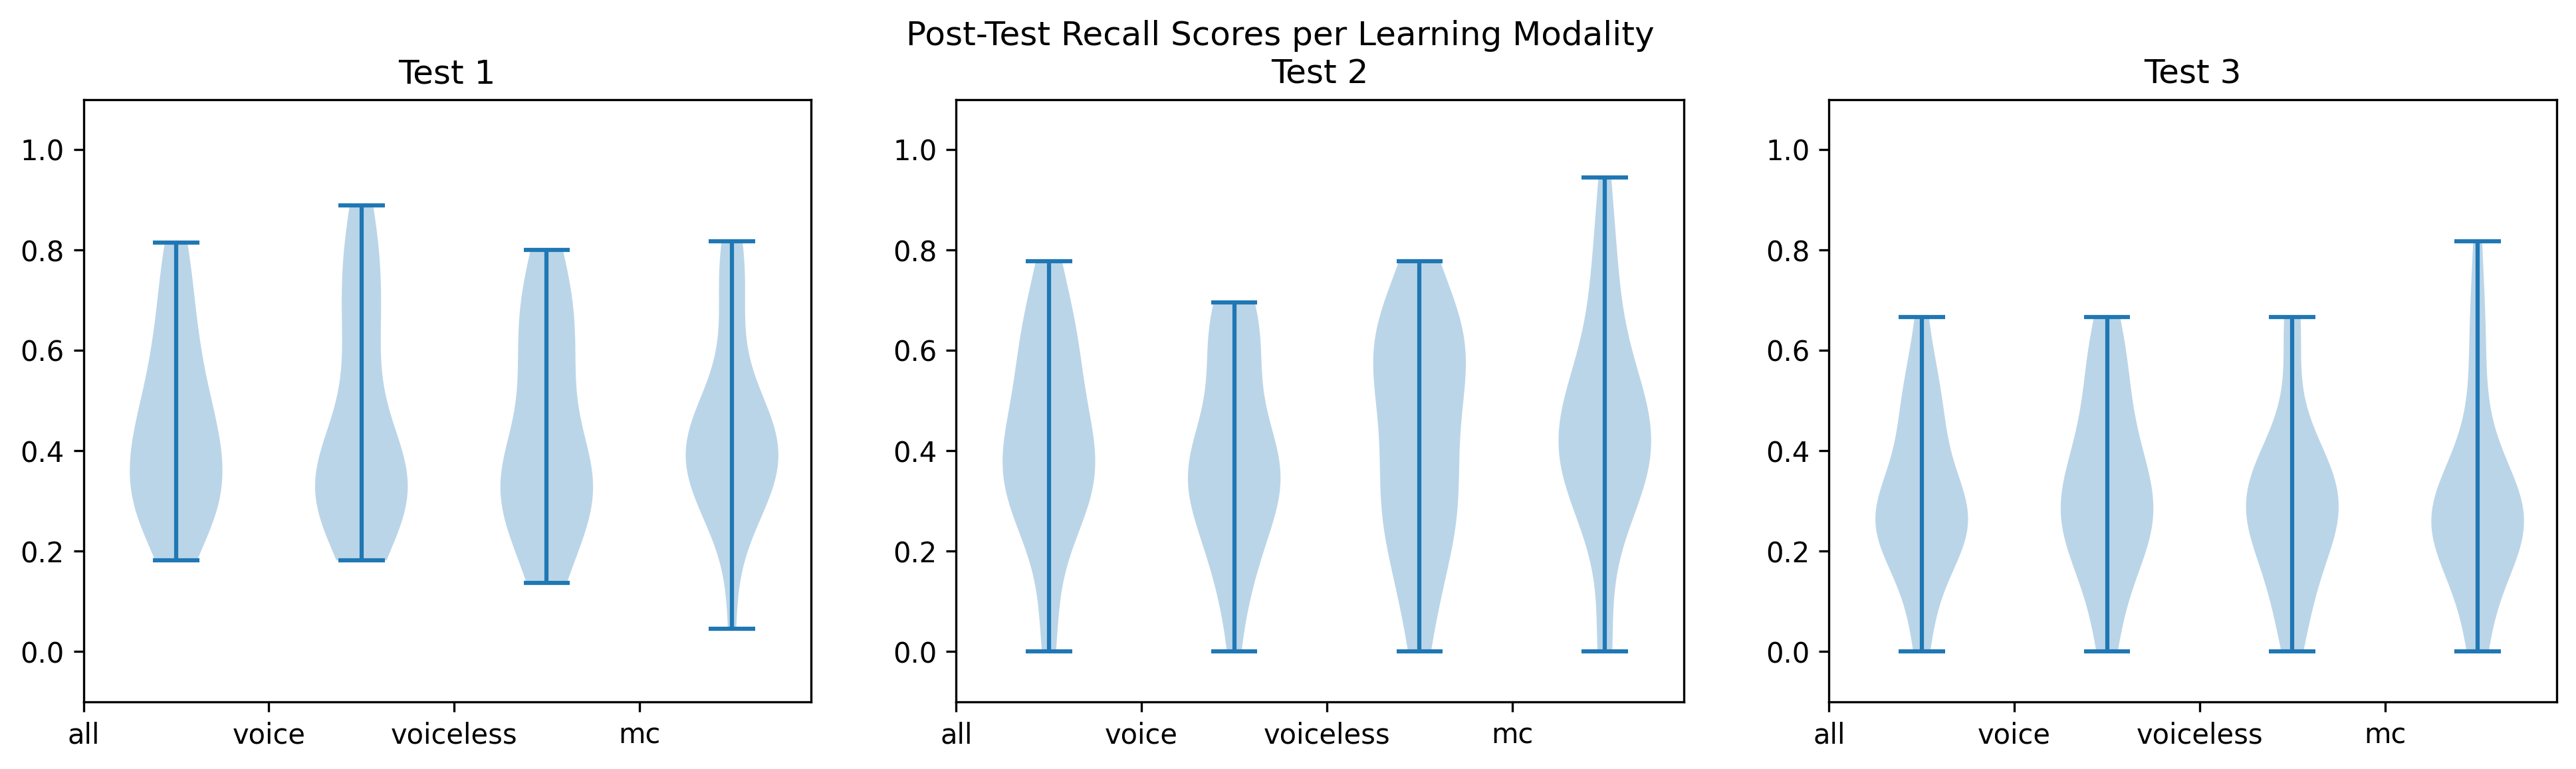

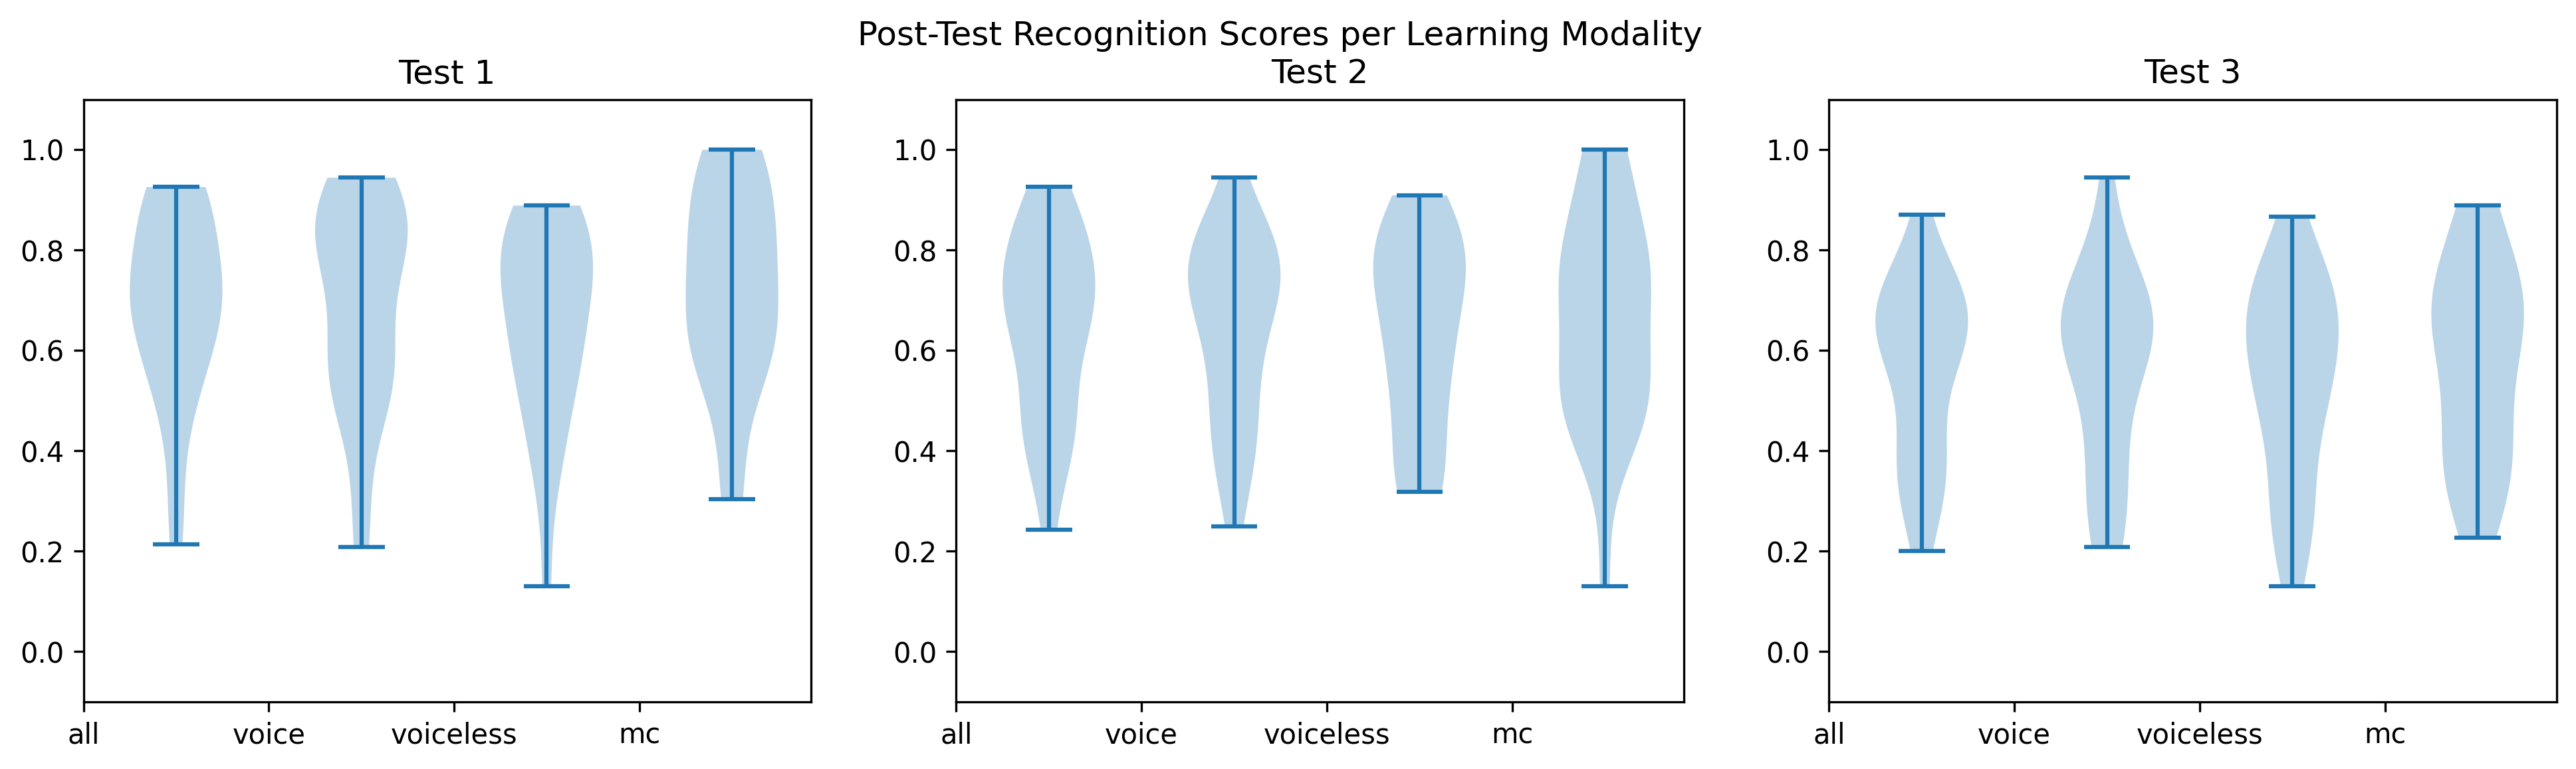

In [20]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].violinplot([accs for _, accs in posttest_recall_acc[i].items()])
  ax[i].axis(ymin=-0.1, ymax=1.1)
  ax[i].set_xticks(np.arange(4) + 0.5, posttest_recall_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")

fig.align_xlabels()
fig.suptitle('Post-Test Recall Scores per Learning Modality')
fig.show()

fig, ax = plt.subplots(1, 3, figsize=(16, 4), dpi = 300)
for i in range(3):
  ax[i].violinplot([accs for _, accs in posttest_recognition_acc[i].items()])
  ax[i].axis(ymin=-0.1, ymax=1.1)
  ax[i].set_xticks(np.arange(4) + 0.5, posttest_recognition_acc[i].keys())
  ax[i].set_title(f"Test {i + 1}")
fig.suptitle('Post-Test Recognition Scores per Learning Modality')
fig.show()


for i in range(3):
  print(f"Recall Test {i + 1}")
  for key, accs in posttest_recall_acc[i].items():
    ks_result = scipy.stats.shapiro(accs)
    print(f"{key} p-value: {ks_result[1]}")

for i in range(3):
  print(f"Recognition Test {i + 1}")
  for key, accs in posttest_recognition_acc[i].items():
    ks_result = scipy.stats.shapiro(accs)
    print(f"{key} p-value: {ks_result[1]}")

## Forgetting Curve

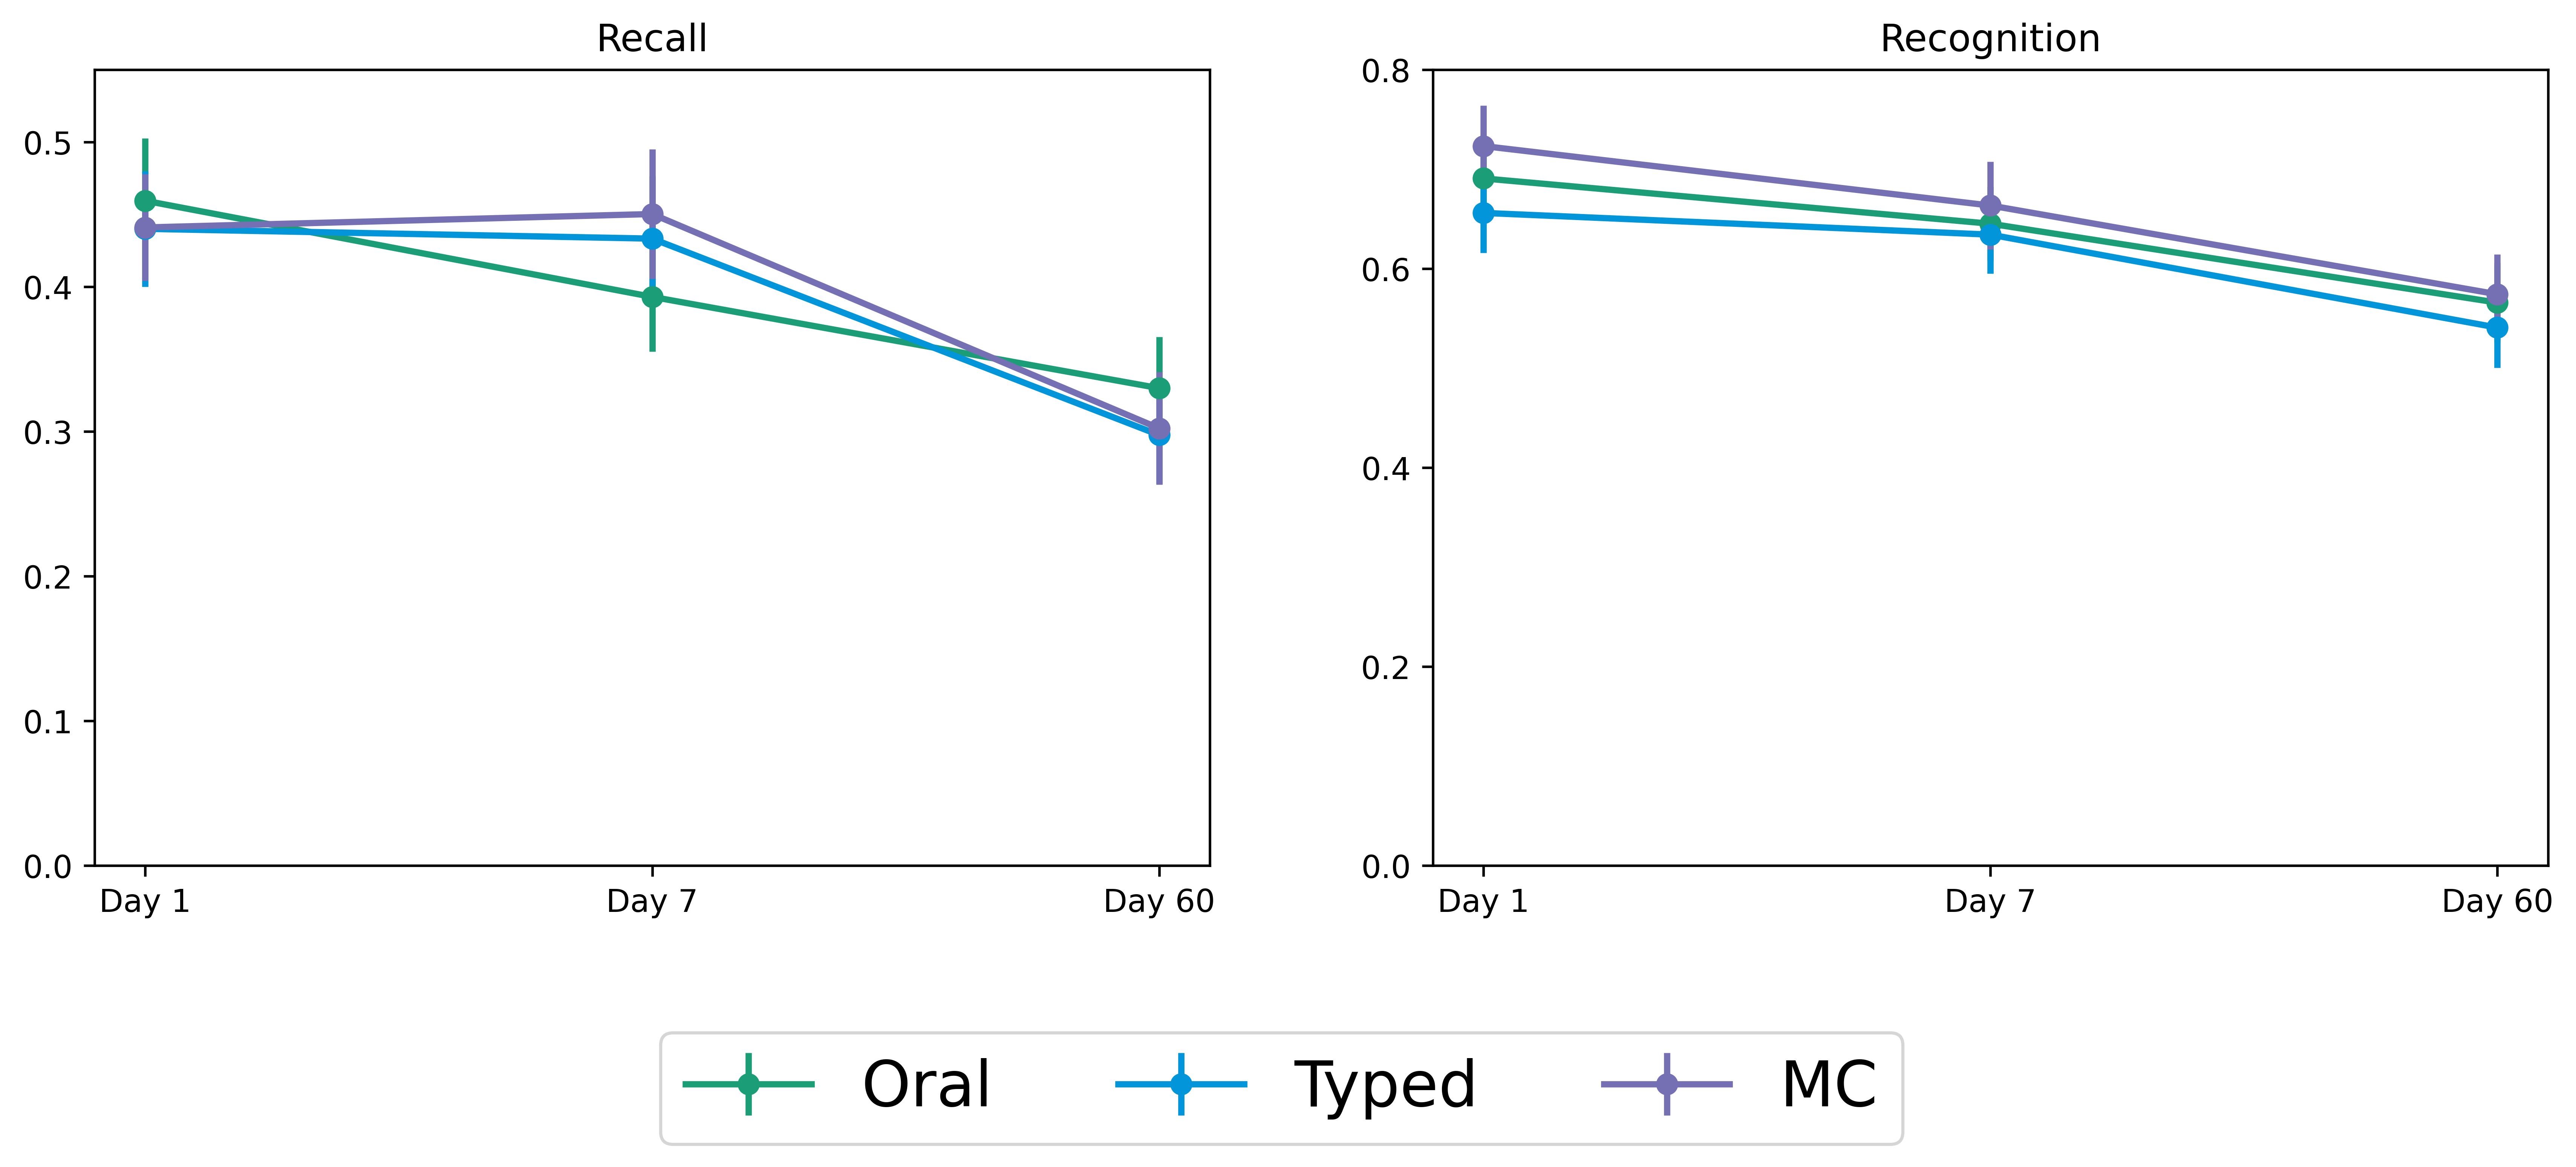

In [21]:
modalities_dict = {'voice': 'Oral', 'voiceless': 'Typed', 'mc': 'MC'}
modalities = ['voice', 'voiceless', 'mc']

mean_posttest_recall_acc = [{modality: np.mean(accs) for modality, accs in posttest_recall_acc[i].items()} for i in range(3)] 
mean_posttest_recall_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recall_acc[i].items()} for i in range(3)]
mean_posttest_recognition_acc = [{modality: np.mean(accs) for modality, accs in posttest_recognition_acc[i].items()} for i in range(3)]
mean_posttest_recognition_sem = [{modality: scipy.stats.sem(accs) for modality, accs in posttest_recognition_acc[i].items()} for i in range(3)]

fig, ax = plt.subplots(1, 2, figsize=(14, 4), dpi=600)
colors = ['#1b9e77', '#0295D9', '#7570b3']

for i, modality in enumerate(modalities):
  ax[0].errorbar(['Day 1', 'Day 7', 'Day 60'], 
                 [mean_posttest_recall_acc[i][modality] for i in range(3)],
                 yerr=[mean_posttest_recall_sem[i][modality] for i in range(3)], 
                 fmt='o-', label=modalities_dict[modality], color=colors[i],
                 linewidth=2)
ax[0].axis(ymin=0, ymax=0.55)
ax[0].set_title("Recall")

# ax[0].set_ylabel('Rate', labelpad=10)


for i, modality in enumerate(modalities):
  ax[1].errorbar(['Day 1', 'Day 7', 'Day 60'], 
                 [mean_posttest_recognition_acc[i][modality] for i in range(3)], 
                 yerr=[mean_posttest_recognition_sem[i][modality] for i in range(3)], 
                 fmt='o-', color=colors[i],
                 linewidth=2)
# ax[1].set_xticks(np.arange(3), ['Day 1', 'Day 7', 'Day 60'])
ax[1].axis(ymin=0, ymax=0.8)
ax[1].set_title("Recognition")

plt.rcParams.update({'font.size': 20})

fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=5)

# less padding for the legend
plt.subplots_adjust(bottom=0)

plt.rcParams.update({'font.size': 20})

fig.show()
fig.savefig('forgetting_curve.png', dpi=600, bbox_inches='tight', transparent=False, pad_inches=0.1, facecolor='white')

## Statistical Comparisons

In [22]:
# https://www.graphpad.com/guides/prism/latest/statistics/
# https://www.marsja.se/repeated-measures-anova-in-python-using-statsmodels/

from statsmodels.stats.anova import AnovaRM
from scipy.stats import wilcoxon, friedmanchisquare, ttest_rel

In [23]:
# Two way RM ANOVA to test whether modality, time of post-test, or interaction between modality and time of post-test has an effect on test accuracy 
# interaction null hypothesis is that the difference between the modalities is the same for all three post-tests

recall_twoway = [['subject_id', 'score', 'modality', 'test_iter']]
for test_iter in range(3):
    for modality, accs in posttest_recall_acc[test_iter].items():
      if modality == "all" or modality == "voiceless":
         continue
      for id, score in enumerate(accs):
         recall_twoway.append([id, score, modality, test_iter])

recog_twoway = [['subject_id', 'score', 'modality', 'test_iter']]
for test_iter in range(3):
    for modality, accs in posttest_recognition_acc[test_iter].items():
      if modality == "all" or modality == "voiceless":
         continue
      for id, score in enumerate(accs):
         recog_twoway.append([id, score, modality, test_iter])

recog_twoway_df = pd.DataFrame(recog_twoway[1:], columns=recog_twoway[0])
recall_twoway_df = pd.DataFrame(recall_twoway[1:], columns=recall_twoway[0])

anova2way = AnovaRM(recog_twoway_df, 'score', 'subject_id', within=['modality', 'test_iter'])
res_recog = anova2way.fit()
anova2way = AnovaRM(recall_twoway_df, 'score', 'subject_id', within=['modality', 'test_iter'])
res_recall = anova2way.fit()
print("Recall", res_recall)
print("Recognition", res_recog)

Recall                      Anova
                   F Value Num DF  Den DF Pr > F
------------------------------------------------
modality            0.0347 1.0000 23.0000 0.8539
test_iter          40.1737 2.0000 46.0000 0.0000
modality:test_iter  4.2726 2.0000 46.0000 0.0199

Recognition                      Anova
                   F Value Num DF  Den DF Pr > F
------------------------------------------------
modality            0.6803 1.0000 23.0000 0.4179
test_iter          23.9333 2.0000 46.0000 0.0000
modality:test_iter  0.5244 2.0000 46.0000 0.5954



In [24]:
for i in range(0, 3):
  print(f"Test {i + 1}")
  anova = AnovaRM(recog_twoway_df[recog_twoway_df['test_iter'] == i], 'score', 'subject_id', within=['modality'])
  res_recog = anova.fit()

  anova = AnovaRM(recall_twoway_df[recall_twoway_df['test_iter'] == i], 'score', 'subject_id', within=['modality'])
  res_recall = anova.fit()

  print("Recall", res_recall)
  print("Recognition", res_recog)
  print('-----------------')


Test 1
Recall                 Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
modality  0.5320 1.0000 23.0000 0.4731

Recognition                 Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
modality  1.4489 1.0000 23.0000 0.2409

-----------------
Test 2
Recall                 Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
modality  3.6131 1.0000 23.0000 0.0699

Recognition                 Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
modality  0.4121 1.0000 23.0000 0.5273

-----------------
Test 3
Recall                 Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
modality  1.1928 1.0000 23.0000 0.2861

Recognition                 Anova
         F Value Num DF  Den DF Pr > F
--------------------------------------
modality  0.0955 1.0000 23.0000 0.7601

-----------------


In [25]:
# "Testing the durability/robustness of learning"
# Friedman to test whether modality has an effect on accuracy in the final, 2-month test: Test 3
for i in range(0, 3):
  print(f"Test {i + 1}")
  recall_table = []
  for modality, accs in posttest_recall_acc[i].items():
    if modality == "all":
      continue
    recall_table.append(accs)

  recog_table = []
  for modality, accs in posttest_recognition_acc[i].items():
    if modality == "all":
      continue
    recog_table.append(accs)

  print("Recall", friedmanchisquare(recall_table[0], recall_table[1], recall_table[2]))
  print("Recognition", friedmanchisquare(recog_table[0], recog_table[1], recog_table[2]))
  print('')

Test 1
Recall FriedmanchisquareResult(statistic=0.8478260869565217, pvalue=0.6544807908076365)
Recognition FriedmanchisquareResult(statistic=6.326086956521739, pvalue=0.042296815550372846)

Test 2
Recall FriedmanchisquareResult(statistic=4.117647058823509, pvalue=0.1276040039797963)
Recognition FriedmanchisquareResult(statistic=1.4888888888888687, pvalue=0.47499811449269647)

Test 3
Recall FriedmanchisquareResult(statistic=3.0, pvalue=0.22313016014842982)
Recognition FriedmanchisquareResult(statistic=2.7555555555555356, pvalue=0.2521382381530056)



In [26]:
# Post-hoc Analysis for Recall

# test_func = ttest_rel
test_func = wilcoxon

# # How to design post-hoc test to explore which two timepoints have a different difference in accuracy between modalities?
# # Wilcoxon to compare (Voice-MC) at time 1 vs (Voice-MC) at time 3 ? Note, these values have a + or - sign.
# print("Wilcoxon to compare (Voice-MC) at time 1 vs (Voice-MC) at time 3")
# stat, p = test_func(np.subtract(posttest_recall_acc[2]['voice'], posttest_recall_acc[2]['mc']), 
#                     np.subtract(posttest_recall_acc[0]['voice'], posttest_recall_acc[0]['mc']))
# print(f"(Voice-MC) at time 3 != at time 1: {p}")

# print("Wilcoxon to compare (Voice-MC) at time 2 vs (Voice-MC) at time 1")
# stat, p = test_func(np.subtract(posttest_recall_acc[1]['voice'], posttest_recall_acc[1]['mc']), 
#                     np.subtract(posttest_recall_acc[0]['voice'], posttest_recall_acc[0]['mc']))
# print(f"(Voice-MC) at time 2 != at time 1: {p}")


print("--------------------")

print("Recall")
stat, p = test_func(posttest_recall_acc[0]['voice'], posttest_recall_acc[0]['mc'])
print(f"Voice != MC (test 1): {p}")

stat, p = test_func(posttest_recall_acc[0]['voice'], posttest_recall_acc[0]['voiceless'])
print(f"Voice != Voiceless (test 1): {p}")

stat, p = test_func(posttest_recall_acc[1]['voice'], posttest_recall_acc[1]['mc'])
print(f"Voice != MC (test 2): {p}")

stat, p = test_func(posttest_recall_acc[1]['voice'], posttest_recall_acc[1]['voiceless'])
print(f"Voice != Voiceless (test 2): {p}")

stat, p = test_func(posttest_recall_acc[2]['voice'], posttest_recall_acc[2]['mc'])
print(f"Voice != MC (test 3): {p}")

stat, p = test_func(posttest_recall_acc[2]['voice'], posttest_recall_acc[2]['voiceless'])
print(f"Voice != Voiceless (test 3): {p}")

print("--------------------")
print("Recognition")

# Post-hoc Analysis for Recognition
stat, p = test_func(posttest_recognition_acc[0]['mc'], posttest_recognition_acc[0]['voice'])
print(f"MC != Voice (test 1): {p}")

stat, p = test_func(posttest_recognition_acc[1]['mc'], posttest_recognition_acc[1]['voice'])
print(f"MC != Voice (test 2): {p}")

stat, p = test_func(posttest_recognition_acc[2]['mc'], posttest_recognition_acc[2]['voice'])
print(f"MC != Voice (test 3): {p}")

--------------------
Recall
Voice != MC (test 1): 0.38600979658349477
Voice != Voiceless (test 1): 0.49079859256744385
Voice != MC (test 2): 0.04586457721958269
Voice != Voiceless (test 2): 0.08534092651572474
Voice != MC (test 3): 0.21720672338836844
Voice != Voiceless (test 3): 0.291300633789112
--------------------
Recognition
MC != Voice (test 1): 0.2295727675118362
MC != Voice (test 2): 0.5230089917974712
MC != Voice (test 3): 0.4223414659500122


/home/arpan/miniconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


## Multivariate Regression

### Participant characteristics

In [27]:
## Participant characteristics
participantInfo = pd.read_csv('/home/arpan/SAIL/backend/users/participants.csv')

# level of schooling
# birthday
# gender
# first language
# preferred language
# country of origin

# filter participantInfo to only include participants who have completed the study
participantInfo = participantInfo[participantInfo['Username'].isin(finished_post_data['email'])]
participantInfo.reset_index(inplace=True, drop=True)

import datetime
def calculate_age(x):
  bday = x['Birthday']
  try:
    age = (datetime.datetime.now() - datetime.datetime.strptime(bday, "%Y-%m-%d")).days / 365
  except Exception as e:
    print(x['Username'], bday)
    age = 26
  return age

participantInfo['age'] = participantInfo.apply(lambda x: calculate_age(x), axis=1)


# in participantInfo['Level of Schooling'], replaces instances of "M4 at UMSOM" with "Medical Student - Year 4" and "MS2" with "Medical Student - Year 2"
participantInfo['Level of Schooling'] = participantInfo['Level of Schooling'].replace("M4 at UMSOM", "Medical Student - Year 4")
participantInfo['Level of Schooling'] = participantInfo['Level of Schooling'].replace("MS2", "Medical Student - Year 2")


participantInfo

# create a XLSX file that can have multiple sheets
writer = pd.ExcelWriter('participantInfo.xlsx', engine='xlsxwriter')

for col in ["Level of Schooling", "age", "Gender", "In which country were you born?", "What was the first language you learned?", "What is your preferred language?"]:
  if col == "age":
    # create a table of summary stats for participantInfo['age'] and save it to a sheet of the xlsx files
    summary_stats = participantInfo['age'].describe()
    # add SEM to summary stats
    summary_stats['SEM'] = participantInfo['age'].sem()
    summary_stats.to_excel(writer, sheet_name=col)
    continue

  value_counts = participantInfo[col].value_counts(normalize=True)
  value_counts = value_counts.to_frame()
  value_counts['count'] = participantInfo[col].value_counts()
  print(value_counts)
  
  # save value counts to a sheet of the xlsx file
  col = col.replace(" ", "_")
  col = col.replace("?", "")
  col = col[:31]
  value_counts.to_excel(writer, sheet_name=col)

# save the xlsx file
writer.save()

robert.liu@som.umaryland.edu nan
                              Level of Schooling  count
Medical Student - Year 4                0.250000      6
Medical Student - Year 2                0.250000      6
Medical Student - Year 1                0.166667      4
Orthopedic Resident - Year 5            0.083333      2
Orthopedic Resident - Year 3            0.083333      2
Medical Student - Year 3                0.083333      2
Orthopedic Resident - Year 1            0.041667      1
Orthopedic Resident - Year 4            0.041667      1
          Gender  count
Female  0.833333     20
Male    0.166667      4
               In which country were you born?  count
USA                                   0.375000      9
United States                         0.291667      7
Canada                                0.083333      2
China                                 0.083333      2
usa                                   0.041667      1
Russia                                0.041667      1
US           

In [28]:
import datetime


# create pandas df from a csv file
participantInfo = pd.read_csv('/home/arpan/SAIL/backend/users/participants.csv')

# trainingDict = {
#   "Orthopedic Resident - Year 5": 9,
#   "Orthopedic Resident - Year 4": 8,
#   "Orthopedic Resident - Year 3": 7,
#   "Orthopedic Resident - Year 2": 6,
#   "Orthopedic Resident - Year 1": 5,
#   "Medical Student - Year 4": 4,
#   "Medical Student - Year 3": 3,
#   "Medical Student - Year 2": 2,
#   "Medical Student - Year 1": 1,
#   "MS2": 2,
#   "M4 at UMSOM": 4,
#   "M2": 2,
#   "Medical Student - MS3": 3
# }

trainingDict = {
  "Orthopedic Resident - Year 5": 6,
  "Orthopedic Resident - Year 4": 5,
  "Orthopedic Resident - Year 3": 4,
  "Orthopedic Resident - Year 2": 3,
  "Orthopedic Resident - Year 1": 2,
  "Medical Student - Year 4": 1,
  "Medical Student - Year 3": 0.5,
  "Medical Student - Year 2": 0,
  "Medical Student - Year 1": 0,
  "MS2": 0,
  "M4 at UMSOM": 1,
  "M2": 0,
  "Medical Student - MS3": 0.5
}

mat = []
for _, row in finished_post_data.iterrows():
  qSched = row['questionSchedule']
  sleepData = row['sleepData']
  meanSleep = np.mean(sleepData)
  varSleep = np.var(sleepData)
  minSleep = np.min(sleepData)
  maxSleep = np.max(sleepData)
  lastSleep = sleepData[-1]

  email = row['email']
  curr_participant = participantInfo[participantInfo['Username'] == email].iloc[0]
  bday = curr_participant['Birthday']
  
  try:
    age = (datetime.datetime.now() - datetime.datetime.strptime(bday, "%Y-%m-%d")).days / 365
  except Exception as e:
    print(email, bday)
    age = 26
    
  gender = curr_participant['Gender'] # CATEGORICAL !
  trainingLevel = trainingDict[curr_participant['Level of Schooling']]

  recall_scores = []
  recog_scores = []
  # 1st post-test
  for y in ['A', 'B']:
    for x in row['first_posttest'][y]:
      if y == 'A':
        score = x['automated_recall_score']
        recall_scores.append(score)
      else:
        QID = x['QID']
        score = 1 if x['response'] == correct_answers[QID] else 0
        recog_scores.append(score)

  test_time = 1
  mat.append([
    meanSleep,
    varSleep,
    minSleep,
    maxSleep,
    lastSleep,
    age,
    gender, 
    trainingLevel,
    test_time,
    np.mean(recall_scores),
    np.mean(recog_scores)
  ])

  
  recall_scores = []
  recog_scores = []
  # 2nd post-test
  for y in ['A', 'B']:
    for x in row['second_posttest'][y]:
      if y == 'A':
        score = x['automated_recall_score']
        recall_scores.append(score)
      else:
        QID = x['QID']
        score = 1 if x['response'] == correct_answers[QID] else 0
        recog_scores.append(score)

  test_time = 7
  mat.append([
    meanSleep,
    varSleep,
    minSleep,
    maxSleep,
    lastSleep,
    age,
    gender, 
    trainingLevel,
    test_time,
    np.mean(recall_scores),
    np.mean(recog_scores)
  ])


  # 3rd post-test
  recall_scores = []
  recog_scores = []
  for y in ['A', 'B']:
    for _, x in row[f'posttest{y}'].iterrows():
      if y == 'A':
        score = x['automated_recall_score']
        recall_scores.append(score)
      else:
        QID = x['QID']
        score = 1 if x['response'] == correct_answers[QID] else 0
        recog_scores.append(score)

  test_time = 60
  mat.append([
    meanSleep,
    varSleep,
    minSleep,
    maxSleep,
    lastSleep,
    age,
    gender, 
    trainingLevel,
    test_time,
    np.mean(recall_scores),
    np.mean(recog_scores)
  ])


df = pd.DataFrame(mat, columns=['meanSleep', "varSleep", "minSleep", "maxSleep", "lastSleep",
                                "age", "gender", "trainingLevel", "test_time", "recallScore", "recogScore"])
df = pd.get_dummies(df, drop_first=True)

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

 
print("RECALL")
lm = ols('recallScore ~ meanSleep + varSleep + minSleep + maxSleep + lastSleep + age + gender_Male + trainingLevel + test_time', df).fit()
print(lm.summary())
anova_table = anova_lm(lm)
print('')
print(anova_table['sum_sq'] / anova_table['sum_sq'].sum())


robert.liu@som.umaryland.edu nan
RECALL
                            OLS Regression Results                            
Dep. Variable:            recallScore   R-squared:                       0.622
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     11.34
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           2.92e-10
Time:                        08:14:42   Log-Likelihood:                 55.704
No. Observations:                  72   AIC:                            -91.41
Df Residuals:                      62   BIC:                            -68.64
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Interc

In [29]:
print("RECOGNITION")
lm = ols('recogScore ~ meanSleep + varSleep + minSleep + maxSleep + lastSleep + age + gender_Male + trainingLevel + test_time', df).fit()
print(lm.summary())
anova_table = anova_lm(lm)
print(anova_table['sum_sq'] / anova_table['sum_sq'].sum())


RECOGNITION
                            OLS Regression Results                            
Dep. Variable:             recogScore   R-squared:                       0.524
Model:                            OLS   Adj. R-squared:                  0.455
Method:                 Least Squares   F-statistic:                     7.594
Date:                Mon, 24 Jul 2023   Prob (F-statistic):           2.08e-07
Time:                        08:14:42   Log-Likelihood:                 45.436
No. Observations:                  72   AIC:                            -70.87
Df Residuals:                      62   BIC:                            -48.10
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0373      0.37

meanSleep | R^2: 0.08147165488064756, Coeff: -0.05487685374295292, p: 0.17637364754957566
varSleep | R^2: 1.629574961525826e-05, Coeff: 0.00026465704480849866, p: 0.9850640959837424
minSleep | R^2: 0.16113981836113767, Coeff: -0.046332325650312645, p: 0.05186567919130694
maxSleep | R^2: 0.02750535661816722, Coeff: -0.02389720444773971, p: 0.43863731017751706
lastSleep | R^2: 0.1409717722895273, Coeff: -0.049423751341790445, p: 0.07060739813410988


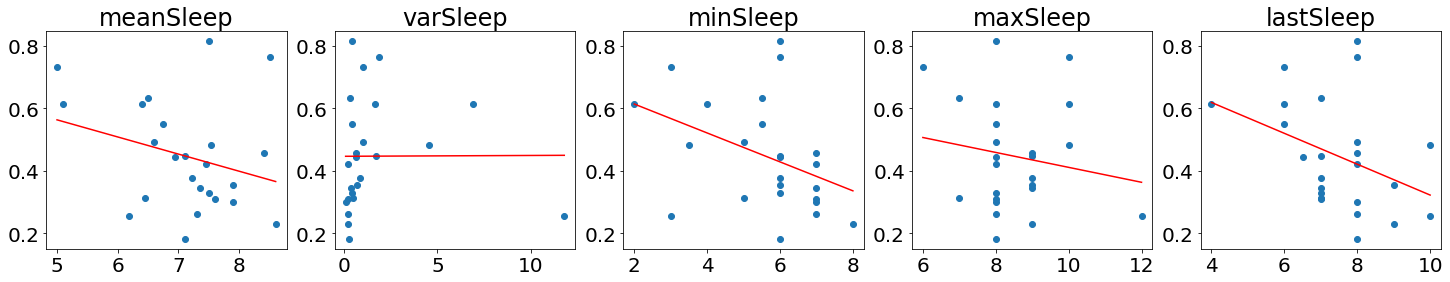

In [30]:
# filter df to test_time = 1
df1 = df[df['test_time'] == 1]

# plot multiple scatterplots in one fig
fig, axs = plt.subplots(1, 5, figsize=(25, 4))

import statsmodels.api as sm

for i, var in enumerate(["meanSleep", "varSleep", "minSleep", "maxSleep", "lastSleep"]):
  axs[i].scatter(df1[var], df1['recallScore'])
  axs[i].set_title(var)

  # linear regression between maxSleep and score 
  x = df1[[var]]
  y = df1['recallScore']
  
  x = sm.add_constant(x) # adding a constant
  mod = sm.OLS(y, x)
  fii = mod.fit()

  # print R^2, coeff, and p-value from fii
  print(f"{var} | R^2: {fii.rsquared}, Coeff: {fii.params[1]}, p: {fii.pvalues[1]}")

  # plot line of best fit on meansleep plot
  x = np.linspace(np.min(df1[var]), np.max(df1[var]), 100)
  y = fii.params[0] + fii.params[1] * x
  axs[i].plot(x, y, color='red')

meanSleep | R^2: 0.20746097175800804, Coeff: -0.208279023288147, p: 0.025308699820256065
varSleep | R^2: 0.021324198404000905, Coeff: 0.19581832599711496, p: 0.4959585418005633
minSleep | R^2: 0.2684045778634244, Coeff: -0.3946167883211678, p: 0.009505912053654217
maxSleep | R^2: 0.008050665521683431, Coeff: -0.05474452554744491, p: 0.6767218493109697
lastSleep | R^2: 0.31603217203209377, Coeff: -0.37545620437956184, p: 0.00424751104666819


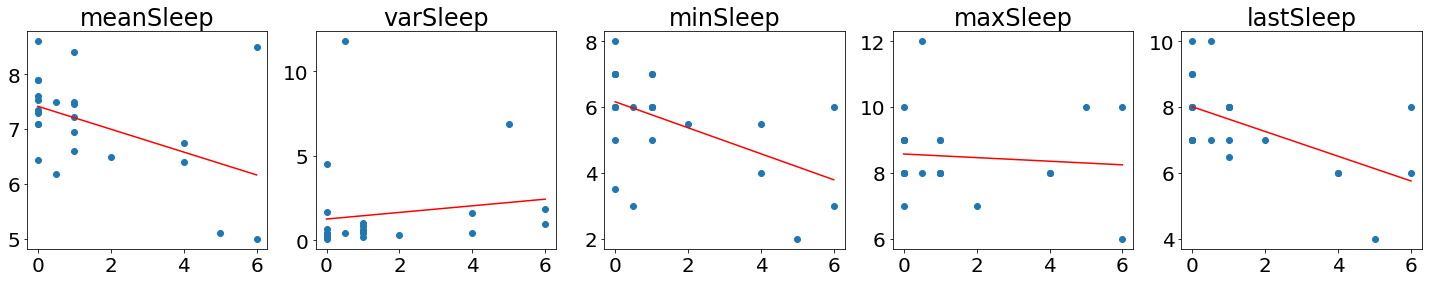

In [31]:
# filter df to test_time = 1
df1 = df[df['test_time'] == 1]
df1

# plot multiple scatterplots in one fig
fig, axs = plt.subplots(1, 5, figsize=(25, 4))

for i, var in enumerate(["meanSleep", "varSleep", "minSleep", "maxSleep", "lastSleep"]):
  axs[i].scatter(df1[['trainingLevel']], df1[[var]])
  axs[i].set_title(var)

  # linear regression between maxSleep and score 
  x = df1[['trainingLevel']]
  y = df1[[var]]

  x = sm.add_constant(x) # adding a constant
  mod = sm.OLS(y, x)
  fii = mod.fit()

  # print R^2, coeff, and p-value from fii
  print(f"{var} | R^2: {fii.rsquared}, Coeff: {fii.params[1]}, p: {fii.pvalues[1]}")

  # plot line of best fit on meansleep plot
  x = np.linspace(np.min(df1['trainingLevel']), np.max(df1['trainingLevel']), 100)
  y = fii.params[0] + fii.params[1] * x
  axs[i].plot(x, y, color='red')

## Survey Results

In [32]:
plt.rcParams.update({'font.size': 20})

# create pandas df from CSV file
df = pd.read_csv('/home/arpan/SAIL/paper/SAIL-Post-Survey.csv')
surveyQuestions = df.iloc[0]
surveyQuestions = surveyQuestions.to_dict()

# drop the 1st row from df
df = df.iloc[1:]

df = df[~df["2"].isin(bad_emails)]
emails = df["2"].unique()
print(emails, "num responses:", len(emails))

arr = [str(x) for x in range(12, 30)]
arr.append("35")
arr.append("3")
df[arr] = df[arr].apply(pd.to_numeric)
surveyQuestions

['maria.novitskaya@som.umaryland.edu' 'Psingh34@jh.edu'
 'logan.kolakowski@som.umaryland.edu' 'andrewbharris@jhmi.edu'
 'tzhang1@som.umaryland.edu' 'rguilba1@jhmi.edu' 'shamil34@jhmi.edu'
 'aweitzn1@jh.edu' 'csong29@jhmi.edu' 'kkuhn14@jh.edu'
 'lyoung1090@gmail.com' 'slin86@jhmi.edu' 'mkubica1@jhmu.edu'
 'Shannon.hanggodo@quinnipiac.edu' 'kzhu24@jhmi.edu' 'mmarani1@jhmi.edu'
 'xdai9@jhmi.edu' 'aatkin31@jhmi.edu' 'szhan129@jh.edu'
 'pvikram1@jhmi.edu'] num responses: 20


{'1': 'Timestamp',
 '2': 'What email did you sign up for the study with?',
 '3': 'How would you rank the quality of the questions administered via SAIL?',
 '4': 'Please comment on what you liked about the voice-based SAIL study app.',
 '5': 'Please comment on what you disliked about the voice-based SAIL study app.',
 '6': 'Which learning modality did you like/enjoy the most?',
 '7': 'Which learning modality would you prefer to use for casual learning (e.g. on the go or while multi-tasking doing something else)?',
 '8': 'Which learning modality would you prefer to use to prepare for real clinical settings (e.g. clinical office visits, floor rounding, and operating room)?',
 '9': 'Which learning modality would you prefer to use for exam preparation?',
 '10': 'Which study modality did you find most effective in general?',
 '11': 'As a result of using SAIL written and voice modes, do you feel you gained knowledge that can help you score higher on an orthopedics in-training exam or written 

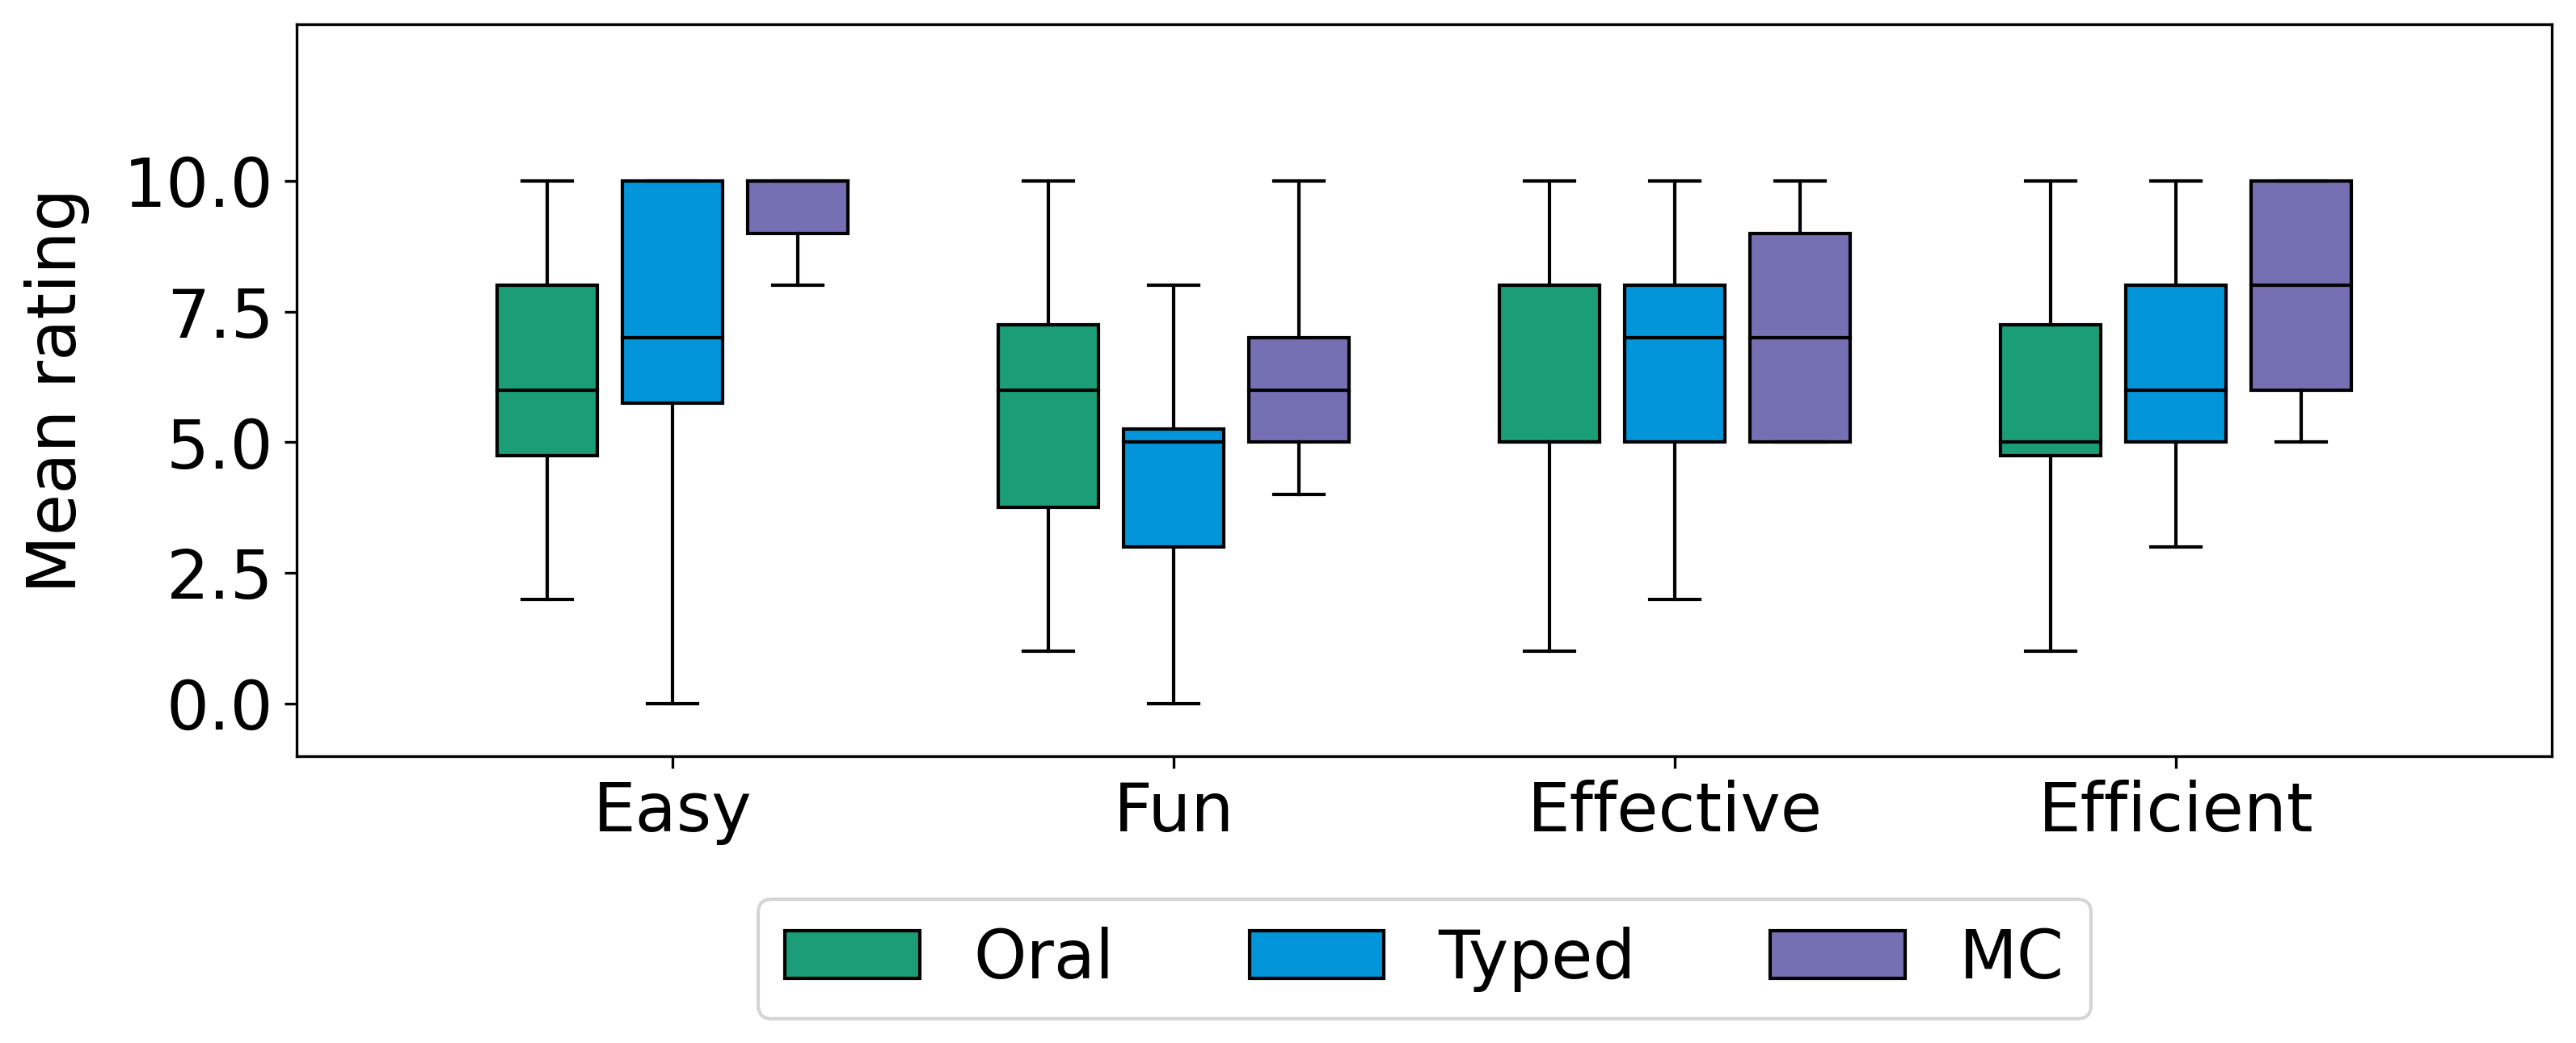

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4), dpi=300)
bar_width = 0.2
ax.set_ylim(-1, 13)
# ax.bar(np.arange(4) - bar_width,
#        [np.mean(df["12"]), np.mean(df["13"]), np.mean(df["14"]), np.mean(df["15"])], width=bar_width, label='Oral', color='#1b9e77', align="center")
# ax.bar(np.arange(4),
#        [np.mean(df["16"]), np.mean(df["17"]), np.mean(df["18"]), np.mean(df["19"])], width=bar_width, label='Typed', color='#0295D9', align="center")
# ax.bar(np.arange(4) + bar_width,
#        [np.mean(df["20"]), np.mean(df["21"]), np.mean(df["22"]), np.mean(df["23"])], width=bar_width, label='MC', color='#7570b3', align="center")

# plot box-and-whisker plot for each question
c='#1b9e77'
bp1 = ax.boxplot([df["12"], df["13"], df["14"], df["15"]], positions=np.arange(4) - bar_width - 0.05, widths=bar_width, showfliers=False,
                 patch_artist=True, boxprops=dict(fc=c, color='black'), 
                 medianprops=dict(color='black'), flierprops=dict(color=c, markeredgecolor=c))

c='#0295D9'
bp2 = ax.boxplot([df["16"], df["17"], df["18"], df["19"]], positions=np.arange(4), widths=bar_width, showfliers=False,
                 patch_artist=True, boxprops=dict(fc=c, color='black'), 
                 medianprops=dict(color='black'), flierprops=dict(color=c, markeredgecolor=c))

c='#7570b3'
bp3 = ax.boxplot([df["20"], df["21"], df["22"], df["23"]], positions=np.arange(4) + bar_width + 0.05, widths=bar_width, showfliers=False,
                 patch_artist=True, boxprops=dict(fc=c, color='black'), 
                 medianprops=dict(color='black'), flierprops=dict(color=c, markeredgecolor=c))


ax.set_xticks(np.arange(4),
              ['Easy', 'Fun', "Effective", 'Efficient'], rotation=0, ha='center')


ax.set_ylabel('Mean rating', labelpad=10)
# ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=5)
ax.legend([bp1["boxes"][0], bp2["boxes"][0], bp3["boxes"][0]], ['Oral', 'Typed', 'MC'], 
          loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=5)

# set y ticks
ax.set_yticks(np.arange(0, 11, 2.5))

# make font sizes way bigger
plt.rcParams.update({'font.size': 20})
plt.show()

# save fig 600 dpi white bg
fig.savefig('ratings.png', dpi=600, bbox_inches='tight', transparent=False, pad_inches=0.1, facecolor='white')

In [39]:
# ANOVA to compare modalities for each of these survey questions (Likert scale comparison)

for i, var in enumerate(["Easy", "Fun", "Effective", "Efficient"]):
  df1 = pd.DataFrame()
  df1["rating"] = df[f"{12+i}"]
  df1["modality"] = "oral"

  df2 = pd.DataFrame()
  df2["rating"] = df[f"{16+i}"]
  df2["modality"] = "typed"

  df3 = pd.DataFrame()
  df3["rating"] = df[f"{20+i}"]
  df3["modality"] = "mc"

  df1 = pd.concat([df1, df2, df3])

  # run a friedman to compare modalities
  anova = friedmanchisquare(df1[df1['modality'] == "oral"]['rating'].to_numpy(), 
                            df1[df1['modality'] == "typed"]['rating'].to_numpy(), 
                            df1[df1['modality'] == "mc"]['rating'].to_numpy())
  # print p-val
  print(var, anova.pvalue)

  # for modality in ["oral", "typed", "mc"]:
  #   print(scipy.stats.shapiro(df1[df1['modality'] == modality]['rating'].to_numpy()))

  # # # run turkey hsd to compare modalities
  # # from statsmodels.stats.multicomp import pairwise_tukeyhsd
  # # m_comp = pairwise_tukeyhsd(endog=df1['rating'], groups=df1['modality'], alpha=0.05)

  # # print(m_comp)

  # run a nonparametric repeated measures test to compare modalities
  stat, p = wilcoxon(df1[df1['modality'] == "oral"]['rating'].to_numpy(), 
                     df1[df1['modality'] == "typed"]['rating'].to_numpy(),
                     correction=True)
  print(f"Oral != Typed: {p}, reject: {True if p < (0.05/3) else False}")

  stat, p = wilcoxon(df1[df1['modality'] == "oral"]['rating'].to_numpy(), 
                     df1[df1['modality'] == "mc"]['rating'].to_numpy(),
                     correction=True)
  print(f"Oral != MC: {p}, reject: {True if p < (0.05/3) else False}")

  stat, p = wilcoxon(df1[df1['modality'] == "typed"]['rating'].to_numpy(), 
                     df1[df1['modality'] == "mc"]['rating'].to_numpy(),
                     correction=True)
  print(f"Typed != MC: {p}, reject: {True if p < (0.05/3) else False}")

  print('')

Easy 0.0002633739996954717
Oral != Typed: 0.22902702524941854, reject: False
Oral != MC: 0.0007388533506522072, reject: True
Typed != MC: 0.0020238502900144294, reject: True

Fun 0.0038213016088316882
Oral != Typed: 0.09641699752074413, reject: False
Oral != MC: 0.2607622073381325, reject: False
Typed != MC: 0.0033554427817717213, reject: True

Effective 0.07304594394698402
Oral != Typed: 0.042798498630346224, reject: False
Oral != MC: 0.035310133155298816, reject: False
Typed != MC: 0.26368156691385924, reject: False

Efficient 0.004703845092237499
Oral != Typed: 0.180626623619073, reject: False
Oral != MC: 0.005321498897125433, reject: True
Typed != MC: 0.021391825189751704, reject: False



/home/arpan/miniconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/arpan/miniconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/arpan/miniconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/arpan/miniconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-val

[0.2, 0.0, 0.8] [0.2, 0.4, 0.4] [0.05, 0.25, 0.7]


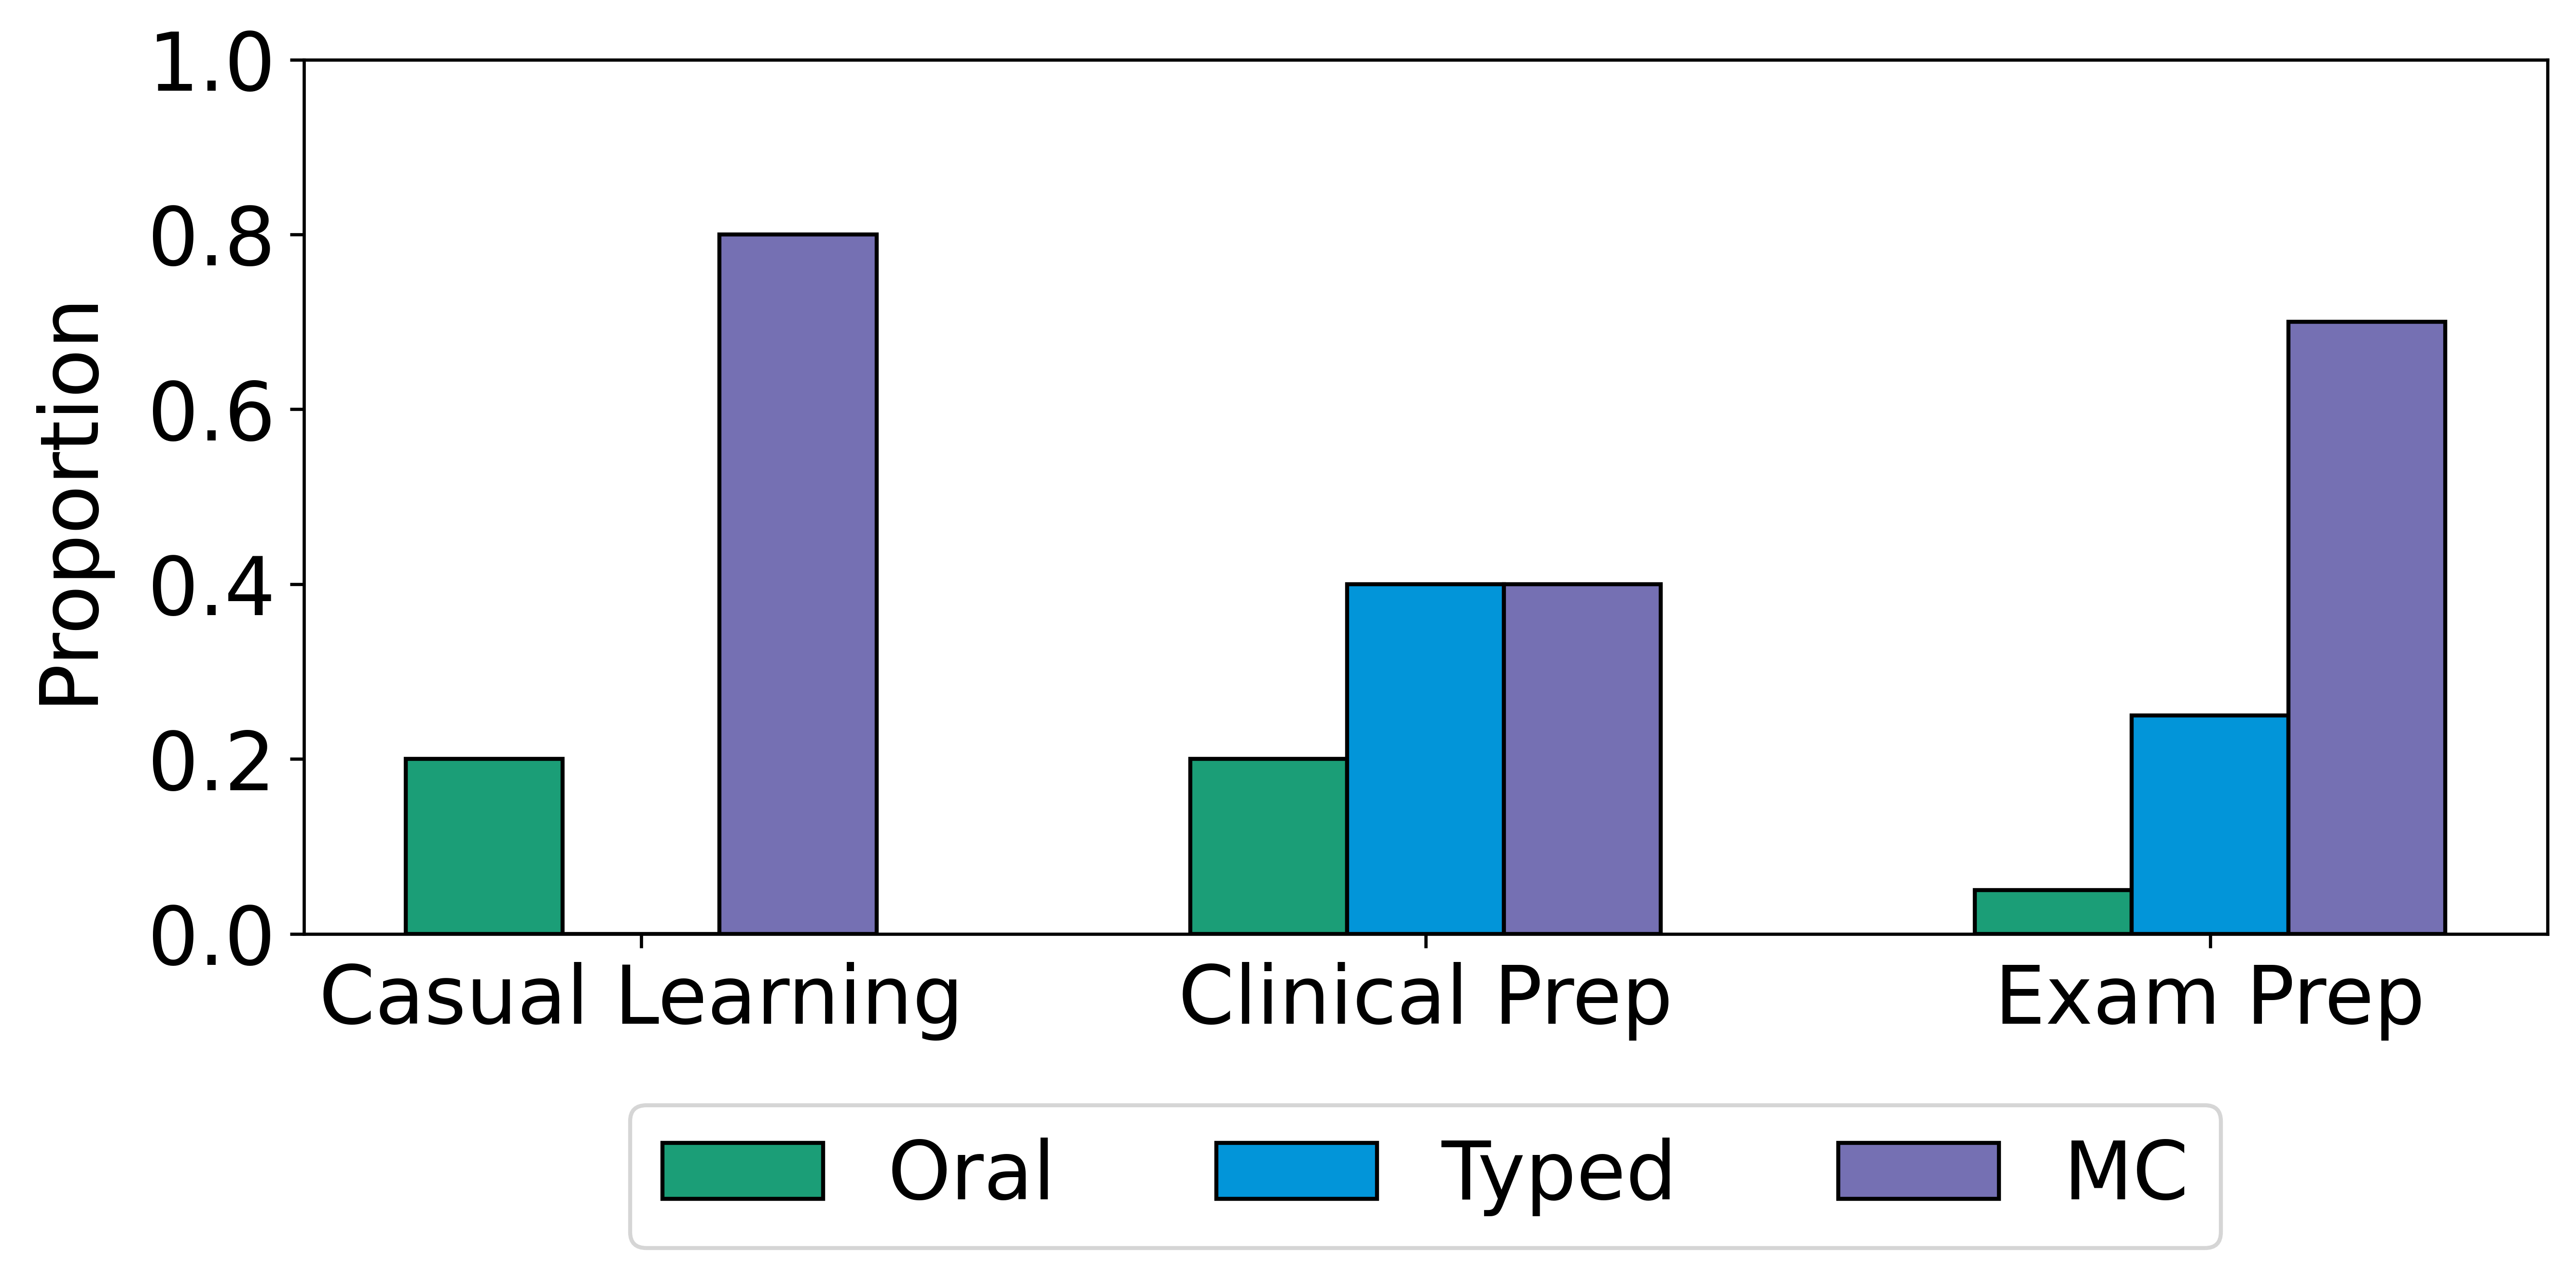

In [56]:
casual = []
clinical = []
exam = []

for index, i in enumerate([7, 8, 9]):
  qNum = str(i)

  # in df[qNum], replace all instances of "Multiple choice" with "MC"
  df[qNum] = df[qNum].replace("Multiple choice", "MC")
  df[qNum] = df[qNum].replace("Multiple Choice", "MC")
  df[qNum] = df[qNum].replace("SAIL study app with voice", "Oral")
  df[qNum] = df[qNum].replace("Written response", "Typed")
  df[qNum] = df[qNum].replace("Written/typed response", "Typed")

  counts = []
  labels = ["Oral", "Typed", "MC"]
  for modality in labels:
    if modality in df[qNum].value_counts():
      counts.append(df[qNum].value_counts()[modality])
    else:
      counts.append(0)
  
  # change counts to a percentage of the sum of counts
  original_counts = counts
  counts = [x / sum(counts) for x in counts]
  if i == 7:
    casual = counts
    casual_original = original_counts
  elif i == 8:
    clinical = counts
    clinical_original = original_counts
  elif i == 9:
    exam = counts
    exam_original = original_counts

print(casual, clinical, exam)

fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=600)
bar_width = 0.2
ax.set_ylim(0, 1)

ax.bar(np.arange(3) - bar_width,
       [x[0] for x in [casual, clinical, exam]], width=bar_width, label='Oral', color='#1b9e77', align="center", ec='black')
ax.bar(np.arange(3),
       [x[1] for x in [casual, clinical, exam]], width=bar_width, label='Typed', color='#0295D9', align="center", ec='black')
ax.bar(np.arange(3) + bar_width,
       [x[2] for x in [casual, clinical, exam]], width=bar_width, label='MC', color='#7570b3', align="center", ec='black')

ax.set_xticks(np.arange(3),
              ['Casual Learning', 'Clinical Prep', "Exam Prep"], rotation=0, ha='center')


ax.set_ylabel('Proportion', labelpad=10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=5)

plt.show()

fig.savefig('proportions_per_setting.png', dpi=600, bbox_inches='tight', transparent=False, pad_inches=0.1, facecolor='white')

In [45]:
# Compare proportions

for var in ["Casual", "Clinical Prep", "Exam Prep"]:
  
  metric = None
  if var == "Casual":
    metric = casual_original
  elif var == "Clinical Prep":
    metric = clinical_original
  elif var == "Exam Prep":
    metric = exam_original
  
  # chi square
  f_obs = metric # [oral, typed, mc]
  chi2, p = scipy.stats.chisquare(f_obs)
  print(f"{var} --> chi-square p: {p}")

  if var == 'Clinical Prep':
    print('')
    continue

  # posthoc
  for i, modality in enumerate(["Oral", "Typed", "MC"]):
    # drop i from f_exp
    f_obs = [x for j, x in enumerate(metric) if j != i]
    chi2, p = scipy.stats.chisquare(f_obs)

    modalities = [x for j,x in enumerate(["Oral", "Typed", "MC"]) if j != i]
    print(f"{modalities} --> chi-square p: {p}, reject = {True if p < (0.05/3) else False}")
  

  print('')

Casual --> chi-square p: 3.0432483008403702e-05
['Typed', 'MC'] --> chi-square p: 6.334248366623988e-05, reject = True
['Oral', 'MC'] --> chi-square p: 0.0072903580915356595, reject = True
['Oral', 'Typed'] --> chi-square p: 0.04550026389635857, reject = False

Clinical Prep --> chi-square p: 0.4493289641172217

Exam Prep --> chi-square p: 0.0012940221054658484
['Typed', 'MC'] --> chi-square p: 0.03894745574202525, reject = False
['Oral', 'MC'] --> chi-square p: 0.0007891129890156312, reject = True
['Oral', 'Typed'] --> chi-square p: 0.10247043485974942, reject = False



In [55]:
#Which learning modality did you like/enjoy the most?
df['6'].value_counts(normalize=True)

Multiple choice              0.90
Written/typed response       0.05
SAIL study app with voice    0.05
Name: 6, dtype: float64

In [54]:
#Would you use SAIL in addition to your current study methods?
df['32'].value_counts(normalize=True)

No                                  0.45
Yes, but with written input only    0.30
Yes, with both modalities           0.25
Name: 32, dtype: float64

In [53]:
# As a result of using SAIL written and voice modes, do you feel you gained knowledge that can help you score higher 
# on an orthopedics in-training exam or written boards exam?
df['11'].value_counts(normalize=True)

No                             0.45
Yes, on both exam types        0.30
Yes, on written board exams    0.20
Yes, on oral board exams       0.05
Name: 11, dtype: float64

## Automatic Free Response Grading

In [213]:
import os
import sys

sys.path.append(os.path.abspath('../backend/scoring'))

In [10]:
import score

scorer = score.new_scorer(root='../backend/scoring', verbose=False)

/home/arpan/miniconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [11]:
for i in range(len(finished_post_data)):
    for posttest_iteration in ['first_posttest', 'second_posttest', "posttestA"]:
        if posttest_iteration == "posttestA":
            posttestA = finished_post_data.iloc[i][posttest_iteration]
        else:
            posttestA = finished_post_data.iloc[i][posttest_iteration]['A']
        
        # if posttest_iteration == "posttestA":
        #     print(posttestA.iloc[0]['start'])
        for j in range(len(posttestA)):
            if posttest_iteration == "posttestA":
                # print(posttestA.iloc[j])
                # print(finished_post_data.iloc[i]['email'], posttest_iteration, posttestA.iloc[j]['QID'], posttestA.iloc[j]["response"])
                posttestA.at[j, "automated_recall_score"] = scorer.score(posttestA.iloc[j]['QID'], posttestA.iloc[j]["response"])
                pass
            else: 
                # print(finished_post_data.iloc[i]['email'], posttest_iteration, posttestA[j]['QID'], posttestA[j]["response"])
                posttestA[j]["automated_recall_score"] = scorer.score(posttestA[j]['QID'], posttestA[j]["response"])

In [12]:
pd.DataFrame(finished_post_data["posttestA"][2])

,QID,automated_recall_score,finish,response,start
0,Trauma 6,0,2023-04-11 02:41:06.686000+00:00,i dont know,2023-04-11 02:40:23.822000+00:00
1,Trauma 7,0,2023-04-11 02:41:50.643000+00:00,mri,2023-04-11 02:41:07.916000+00:00
2,Trauma 30,0,2023-04-11 02:42:03.521000+00:00,type iii,2023-04-11 02:41:51.697000+00:00
3,Recon 26,0,2023-04-11 02:42:12.152000+00:00,i dont know,2023-04-11 02:42:04.557000+00:00
4,Pediatrics 11,1,2023-04-11 02:42:18.414000+00:00,esr,2023-04-11 02:42:13.059000+00:00
5,Recon 12,0,2023-04-11 02:42:28.434000+00:00,i dont know,2023-04-11 02:42:19.622000+00:00
6,Trauma 19,0,2023-04-11 02:42:43.010000+00:00,i dont know,2023-04-11 02:42:29.273000+00:00
7,Pediatrics 1,0,2023-04-11 02:42:57.285000+00:00,i dont know,2023-04-11 02:42:43.906000+00:00
8,Pediatrics 6,0,2023-04-11 02:43:05.852000+00:00,i dont know,2023-04-11 02:42:58.122000+00:00
9,Pediatrics 17,0,2023-04-11 02:43:14.692000+00:00,vitamin d,2023-04-11 02:43:06.765000+00:00


In [11]:
pd.DataFrame(finished_post_data["first_posttest"][0]["A"])

,QID,automated_recall_score,finish,response,start
0,Pediatrics 23,1,2023-01-13 13:19:49.992000+00:00,Observation,2023-01-13 13:19:42.242000+00:00
1,Pediatrics 9,1,2023-01-13 13:20:00.103000+00:00,Rib vertebral angle,2023-01-13 13:19:50.920000+00:00
2,Trauma 17,1,2023-01-13 13:20:11.380000+00:00,Tuberosity malposition,2023-01-13 13:20:01.464000+00:00
3,Recon 12,1,2023-01-13 13:20:30.937000+00:00,Irrigation and debridement with intraoperative...,2023-01-13 13:20:12.740000+00:00
4,Recon 30,1,2023-01-13 13:20:49.056000+00:00,Femoral component anterior translation during ...,2023-01-13 13:20:31.863000+00:00
5,Trauma 7,1,2023-01-13 13:20:58.013000+00:00,Intraoperative fluoroscopy,2023-01-13 13:20:50.096000+00:00
6,Pediatrics 24,1,2023-01-13 13:21:08.499000+00:00,Left sided hypoplasia,2023-01-13 13:20:58.972000+00:00
7,Recon 28,0,2023-01-13 13:21:18.936000+00:00,Anterior inferior quadrant,2023-01-13 13:21:09.767000+00:00
8,Recon 11,0,2023-01-13 13:21:45.219000+00:00,"Reduced ductility/fragility, Increased strength",2023-01-13 13:21:19.742000+00:00
9,Recon 10,0,2023-01-13 13:21:54.493000+00:00,Reduced ductility,2023-01-13 13:21:46.128000+00:00


In [13]:
for posttest_iteration in ['posttestA', 'first_posttest', 'second_posttest']:
    print(f"Scoring {posttest_iteration}")
    for email, posttest in tqdm.tqdm(list(zip(finished_post_data['email'], finished_post_data[posttest_iteration]))):
        with open(f'../backend/users/{email}.yaml') as f:
            user_data = yaml.safe_load(f)
        
        if posttest_iteration != "posttestA": 
            for q, posttest_q in zip(user_data[posttest_iteration]["A"], posttest["A"]):
                q['automated_recall_score'] = posttest_q["automated_recall_score"]
        else:
            posttest_array = [posttest.iloc[i].to_dict() for i in range(posttest.shape[0])]
            for q, posttest_q in zip(user_data[posttest_iteration], posttest_array):
                q['automated_recall_score'] = int(posttest_q["automated_recall_score"])
        
        with open(f'../backend/users/{email}.yaml', 'w') as f:
            yaml.dump(user_data, f)

  0%|          | 0/28 [00:00<?, ?it/s]

Scoring posttestA


  0%|          | 0/28 [00:00<?, ?it/s]

Scoring first_posttest


  0%|          | 0/28 [00:00<?, ?it/s]

Scoring second_posttest


100%|██████████| 28/28 [00:22<00:00,  1.27it/s]


## Sleep Data

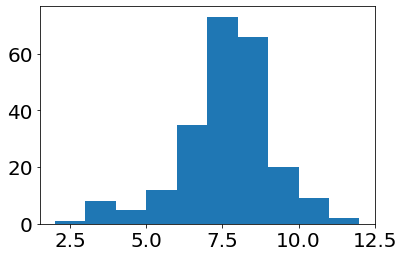

Sleep
Min: 2.0
Median: 7.0
Max: 12.0
Mean: 7.152597402597403
SEM: 0.10036480058782797


In [35]:
sleep=finished_post_data['sleepData'].to_numpy()
sleep=np.concatenate(sleep)
plt.hist(sleep)
plt.show()

print("Sleep")
print(f"Min: {np.min(sleep)}")
print(f"Median: {np.median(sleep)}")
print(f"Max: {np.max(sleep)}")
print(f"Mean: {np.mean(sleep)}")
print(f"SEM: {scipy.stats.sem(sleep)}")


# average sleep hrs might be an important factor
# but also variability in sleep for a person might be important
# or min